In [ ]:
# Cell 1: Install required packages
%pip install pymongo python-dotenv pandas seaborn matplotlib ipython boto3 anthropic
%!pip install markdown

Configuration

In [1]:
# Cell 2: Configuration Setup
import os
from dotenv import load_dotenv
from data_extractor import MongoDBExtractor
from datetime import datetime, timedelta
import pandas as pd

# Load environment variables
load_dotenv()

# Initialize MongoDB extractor
extractor = MongoDBExtractor()
extractor.connect()

# 1. Selected users for analysis (subset of 3 from config.py)
test_users = TARGET_USERS = [
    "Meir_Rubin", "MisgavINS", "ptr_dvd", "AmiadCohen", "EVKontorovich",
    "SagiBarmak", "KoheletForum", "rotem_sella", "ShimonNataf", "russell_sl",
    "MalkaElad", "SaraHaetzniCohe", "berale_crombie", "Argaman_Inst",
    "ShovalRonen", "Shauli_Sharf", "DBortnovskiy", "hashiloach",
    "SellaMeirPress", "LawLibertyForum", "Meshilut", "MalkaElad", "matanp2"
]
print("Users to analyze:", test_users)

# 2. Define analysis periods
pre_war_end = '2023-10-07'    # Day before the war
post_war_start = '2024-12-30'  # War start date
days_back = 90                 # Days to analyze for each period

# Create timestamp objects for reference
pre_war_end_date = datetime.strptime(pre_war_end, '%Y-%m-%d')
post_war_start_date = datetime.strptime(post_war_start, '%Y-%m-%d')

# 3. Additional parameters
MODEL_NAME = "anthropic.claude-3-5-haiku-20241022-v1:0"  # Current model
os.environ['MODEL_NAME'] = MODEL_NAME

# Directory structure for data organization
DATA_DIRS = {
    'raw': os.path.join('data', 'raw'),
    'pre_war': os.path.join('data', 'raw', 'pre_war'),
    'post_war': os.path.join('data', 'raw', 'post_war'),
    'analysis': os.path.join('data', 'analysis'),
    'cleaned': os.path.join('data', 'cleaned')
}

# Create necessary directories
for dir_path in DATA_DIRS.values():
    os.makedirs(dir_path, exist_ok=True)

print(f"\nAnalysis Configuration:")
print(f"Pre-war period: {pre_war_end_date - timedelta(days=days_back)} to {pre_war_end_date}")
print(f"Post-war period: {post_war_start_date - timedelta(days=days_back)} to {post_war_start_date}")
print(f"Days analyzed per period: {days_back}")
print(f"Model: {MODEL_NAME}")

Successfully connected to MongoDB
Users to analyze: ['Meir_Rubin', 'MisgavINS', 'ptr_dvd', 'AmiadCohen', 'EVKontorovich', 'SagiBarmak', 'KoheletForum', 'rotem_sella', 'ShimonNataf', 'russell_sl', 'MalkaElad', 'SaraHaetzniCohe', 'berale_crombie', 'Argaman_Inst', 'ShovalRonen', 'Shauli_Sharf', 'DBortnovskiy', 'hashiloach', 'SellaMeirPress', 'LawLibertyForum', 'Meshilut', 'MalkaElad', 'matanp2']

Analysis Configuration:
Pre-war period: 2023-07-09 00:00:00 to 2023-10-07 00:00:00
Post-war period: 2024-10-01 00:00:00 to 2024-12-30 00:00:00
Days analyzed per period: 90
Model: anthropic.claude-3-5-haiku-20241022-v1:0


Fetch data

In [3]:
# Cell 3: Fetch and Clean Data
from tweet_cleaner import TweetCleaner
print("\nFetching and cleaning data for both periods...")

# Initialize tweet cleaner with all parameters enabled
cleaner = TweetCleaner(min_words=7, remove_mentions=True, remove_urls=True)

# Process pre-war data
print("\nProcessing pre-war period data...")
pre_war_df = extractor.extract_tweets_by_date_range(
    reference_date=pre_war_end,
    days_back=days_back,
    usernames=test_users,
    period_label='pre_war'
)
pre_war_cleaned = cleaner.clean_tweets(pre_war_df, period_label='pre_war')
print(f"Pre-war tweets after cleaning: {len(pre_war_cleaned)}")

# Process post-war data
print("\nProcessing post-war period data...")
post_war_df = extractor.extract_tweets_by_date_range(
    reference_date=post_war_start,
    days_back=days_back,
    usernames=test_users,
    period_label='post_war'
)
post_war_cleaned = cleaner.clean_tweets(post_war_df, period_label='post_war')
print(f"Post-war tweets after cleaning: {len(post_war_cleaned)}")


Fetching and cleaning data for both periods...

Processing pre-war period data...
Successfully connected to MongoDB
Fetching tweets from 2023-07-09 00:00:00 to 2023-10-07 23:59:59
Using timestamps from 1688850000 to 1696712399
Fetched 24 tweets for Meir_Rubin
Fetched 2 tweets for MisgavINS
Fetched 194 tweets for ptr_dvd
Fetched 217 tweets for AmiadCohen
Fetched 22 tweets for EVKontorovich
Fetched 164 tweets for SagiBarmak
Fetched 79 tweets for KoheletForum
Fetched 355 tweets for rotem_sella
Fetched 184 tweets for ShimonNataf
Fetched 373 tweets for russell_sl
Fetched 21 tweets for MalkaElad
Fetched 110 tweets for SaraHaetzniCohe
Fetched 92 tweets for berale_crombie
Fetched 16 tweets for Argaman_Inst
Fetched 27 tweets for ShovalRonen
Fetched 17 tweets for Shauli_Sharf
Fetched 6 tweets for DBortnovskiy
Fetched 7 tweets for hashiloach
Fetched 24 tweets for SellaMeirPress
Fetched 18 tweets for LawLibertyForum
Fetched 139 tweets for Meshilut
Fetched 21 tweets for MalkaElad
Fetched 42 tweets

Enhanced users analysis

In [4]:
# Cell 4: Analyze Individual Users
from analyzer import TweetAnalyzer
from analyzer_enhanced import EnhancedTweetAnalyzer
print("\nAnalyzing individual users for both periods...")

# Initialize analyzers
basic_analyzer = TweetAnalyzer(batch_size=50, max_retries=3)
enhanced_analyzer = EnhancedTweetAnalyzer(batch_size=50, max_retries=3)

# Process pre-war period
print("\nAnalyzing pre-war period...")

# Step 1: Basic Analysis
pre_war_analyses = []
for username in pre_war_cleaned['author_username'].unique():
    user_tweets = pre_war_cleaned[pre_war_cleaned['author_username'] == username].to_dict('records')
    analysis = basic_analyzer.analyze_user_tweets(username, user_tweets)
    pre_war_analyses.append(analysis)
pre_war_merged = basic_analyzer.merge_user_analyses(pd.concat(pre_war_analyses), period_label='pre_war')
print(f"Completed basic pre-war analysis for {len(pre_war_merged)} users")

# Step 2: Enhanced Analysis (passing both merged analysis and cleaned tweets)
pre_war_enhanced = enhanced_analyzer.merge_user_analyses_enhanced(
    df=pre_war_merged,
    tweets_df=pre_war_cleaned,
    period_label='pre_war'
)
print(f"Completed enhanced pre-war analysis")

# Process post-war period
print("\nAnalyzing post-war period...")

# Step 1: Basic Analysis
post_war_analyses = []
for username in post_war_cleaned['author_username'].unique():
    user_tweets = post_war_cleaned[post_war_cleaned['author_username'] == username].to_dict('records')
    analysis = basic_analyzer.analyze_user_tweets(username, user_tweets)
    post_war_analyses.append(analysis)
post_war_merged = basic_analyzer.merge_user_analyses(pd.concat(post_war_analyses), period_label='post_war')
print(f"Completed basic post-war analysis for {len(post_war_merged)} users")

# Step 2: Enhanced Analysis (passing both merged analysis and cleaned tweets)
post_war_enhanced = enhanced_analyzer.merge_user_analyses_enhanced(
    df=post_war_merged,
    tweets_df=post_war_cleaned,
    period_label='post_war'
)
print(f"Completed enhanced post-war analysis")


Analyzing individual users for both periods...

Analyzing pre-war period...

Analyzing tweets for @Meir_Rubin
Total tweets: 14
Number of batches: 1
✓ Batch 1/1 completed

Completed analysis for @Meir_Rubin: 1 batches processed

Analyzing tweets for @MisgavINS
Total tweets: 2
Number of batches: 1
✓ Batch 1/1 completed

Completed analysis for @MisgavINS: 1 batches processed

Analyzing tweets for @ptr_dvd
Total tweets: 145
Number of batches: 3
✓ Batch 1/3 completed
✓ Batch 2/3 completed
✓ Batch 3/3 completed

Completed analysis for @ptr_dvd: 3 batches processed

Analyzing tweets for @AmiadCohen
Total tweets: 171
Number of batches: 4
✓ Batch 1/4 completed
✓ Batch 2/4 completed
✓ Batch 3/4 completed
✓ Batch 4/4 completed

Completed analysis for @AmiadCohen: 4 batches processed

Analyzing tweets for @EVKontorovich
Total tweets: 17
Number of batches: 1
✓ Batch 1/1 completed

Completed analysis for @EVKontorovich: 1 batches processed

Analyzing tweets for @SagiBarmak
Total tweets: 121
Number 

Users analysis report

# User Analysis Report

## Analysis for @Meir_Rubin

### Tweet Volume

- Pre-war tweets: 14
- Post-war tweets: 1,207
- Change: +1,193 (+8521.4%)

### Most Intense Tweets

_Note: Content rated as low toxicity pre-war and moderately assertive post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
רוטמן: 'האם בהפגנה מול פורום קהלת הותקף המנכ
```


**Post-war Period:**

```
צריך להרוג בדחיפות את רעיון החמאס גם ביהודה, שומרון וירדן.
```

```
קריאה לסרבנות באמצע מלחמה איננה מחאה - היא פגיעה ישירה בביטחון המדינה
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    25.0
Post-war:   57.4
Change:    +32.4
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    50.0
Post-war:   36.1
Change:    -13.9
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    50.0
Post-war:   72.1
Change:    +22.1
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    75.0
Post-war:   76.3
Change:     +1.3
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Media critique of political organizations

- Professional commentary on social movements

- Personal experiences with political discourse


**Post-war Top 3 Narratives:**

- Judicial reform is necessary and urgent

- Military service is critical national duty

- Challenge existing government and legal institutions


**Analysis of Changes:**

_The focus shifted from critiquing political organizations and social movements to emphasizing judicial reform, military service, and challenging government and legal institutions in the post-war narratives._


### New Entities Criticized

- Supreme Court

- UNRWA

- Hamas


### No Longer Criticized

- Kohelet Forum

- Steve Adler

### Data Visualization


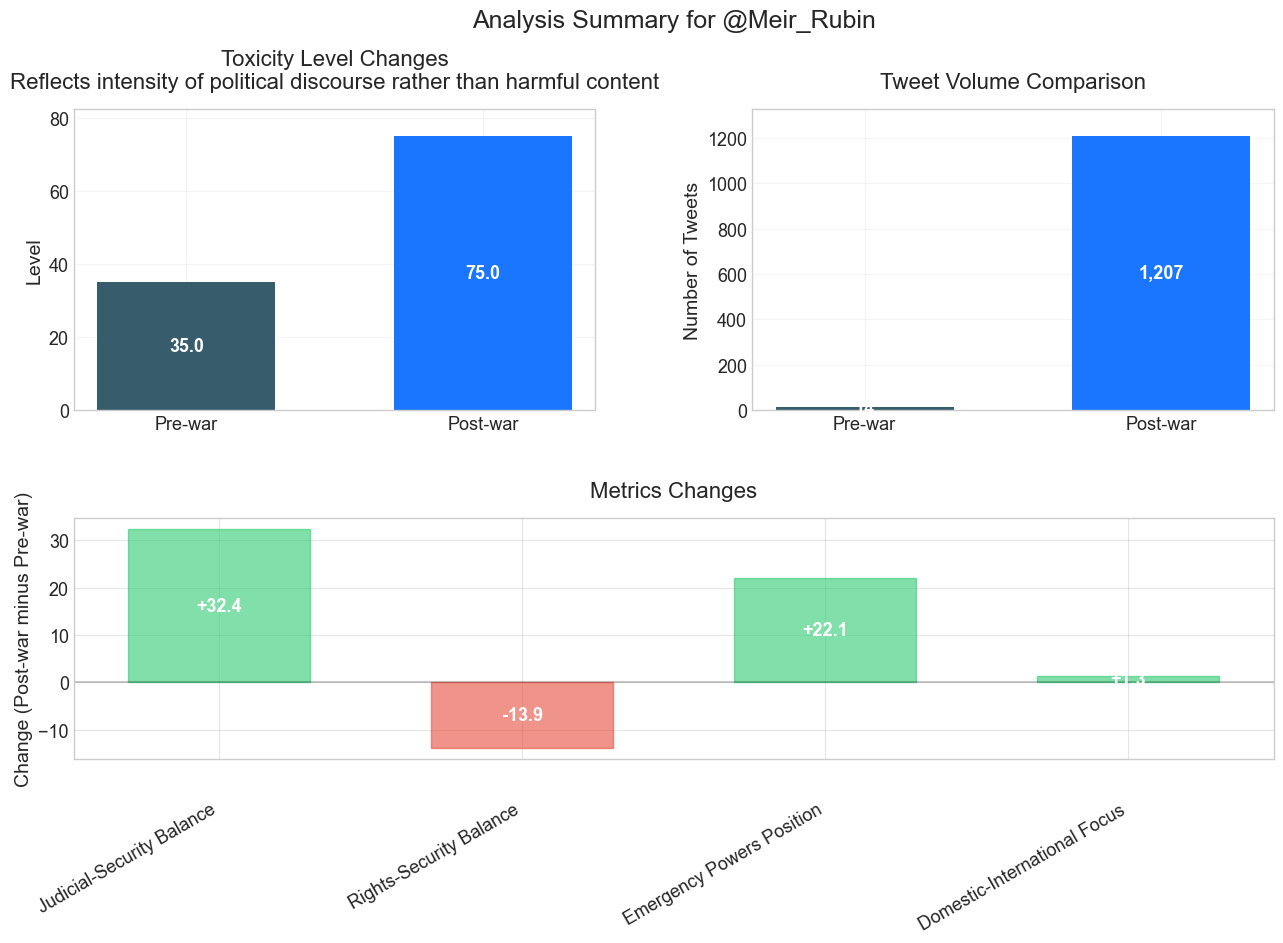

---

# User Analysis Report

## Analysis for @MisgavINS

### Tweet Volume

- Pre-war tweets: 2
- Post-war tweets: 214
- Change: +212 (+10600.0%)

### Most Intense Tweets

_Note: Content rated as low toxicity pre-war and low toxicity post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
נכון להגביר את מאמצי הסיכול במיוחד כנגד תשתיות חמאס בכל שטחי יו"
```

```
הגבלת תנועת עובדים פלסטינים כאסטרטגיה ביטחונית
```


**Post-war Period:**

```
שוב, היהודים הם אלו שמאלצים את העולם לעשות בחירה מוסרית.
```

```
הם בהחלט ינסו להטות את כל המזה\'
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    25.0
Post-war:   35.1
Change:    +10.1
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    25.0
Post-war:   25.0
Change:     +0.0
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    75.0
Post-war:   75.0
Change:     +0.0
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    50.0
Post-war:   47.9
Change:     -2.1
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Regional security strategy development

- Palestinian labor movement control

- Strategic national security approach


**Post-war Top 3 Narratives:**

- Weaken Iranian regional influence

- US-Israel strategic realignment needed

- Reshape Middle East geopolitical dynamics


**Analysis of Changes:**

_The focus shifted from regional security, labor control, and national security to weakening Iranian influence, realigning US-Israel relations, and reshaping Middle East geopolitics._


### New Entities Criticized

- Iran

- Hezbollah


### No Longer Criticized

- Palestinian workers

- Palestinian infrastructure

### Data Visualization


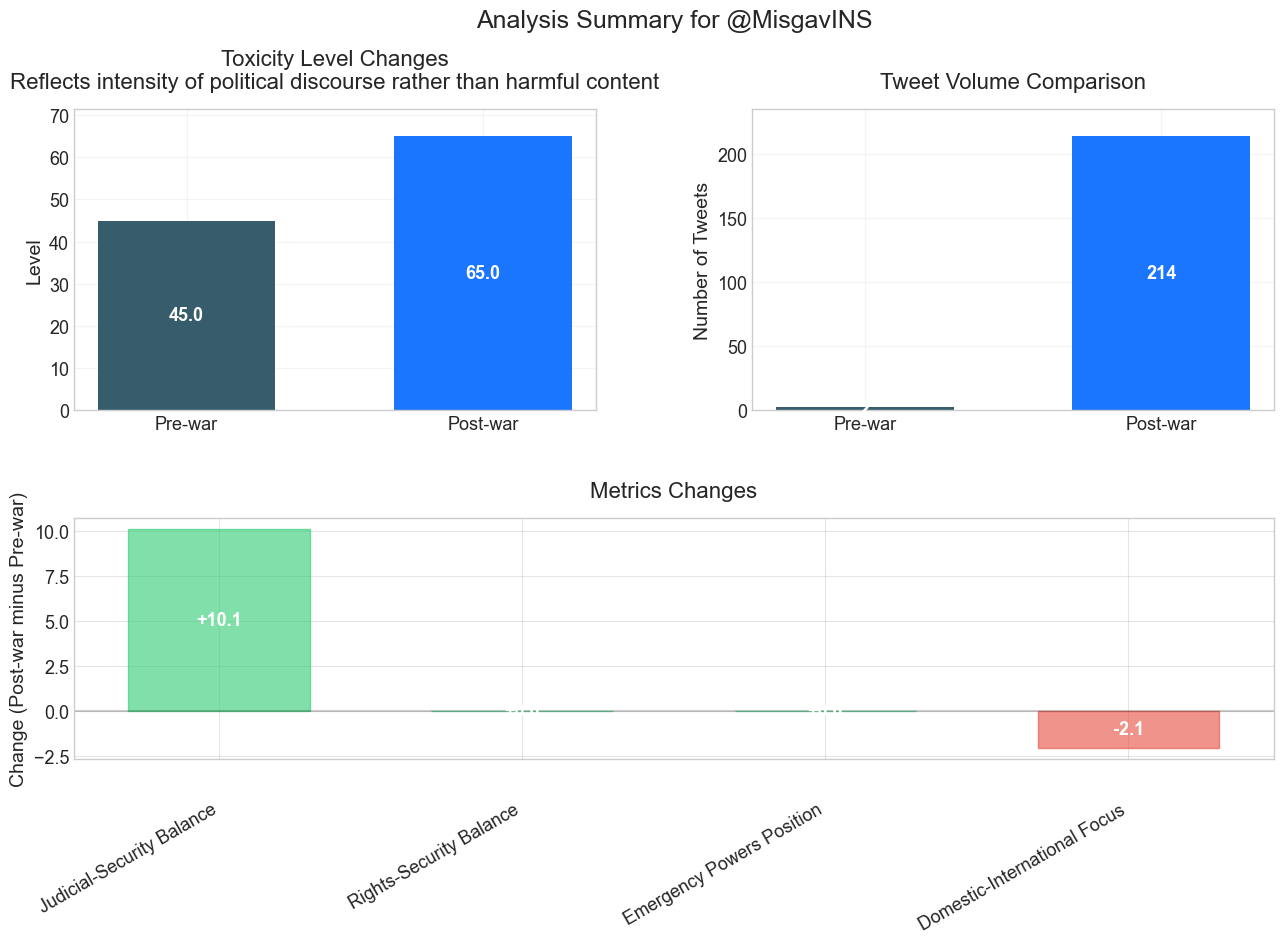

---

# User Analysis Report

## Analysis for @ptr_dvd

### Tweet Volume

- Pre-war tweets: 145
- Post-war tweets: 410
- Change: +265 (+182.8%)

### Most Intense Tweets

_Note: Content rated as moderately assertive pre-war and moderately assertive post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
מה? מתי נתניהו הוריש את השלטון למישהו?
```

```
מוסרית מדובר במעשה מתועב ושפל. אך יש קשיים תאורטיים לא מבוטלים ביישום הפללה של שקרים שקודמים ליחסי מין.
```


**Post-war Period:**

```
אנחנו במלחמת אזרחים קרה אבל אין פה שני מחנות. יש מחנה במלחמת אזרחים ויש מחנה שמתחנן
```

```
אנשים כמו גנץ, ליברמן, בוז'י ולפיד זיהו שהמטורפים שמבעירים את המדינה מועילים להם פוליטית
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    78.5
Post-war:   72.8
Change:     -5.7
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    59.0
Post-war:   38.3
Change:    -20.8
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    71.7
Post-war:   69.3
Change:     -2.4
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    88.4
Post-war:   85.3
Change:     -3.1
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Judicial reform is necessary for democratic balance

- Supreme Court wields arbitrary power

- Political opposition undermines national interests


**Post-war Top 3 Narratives:**

- Judicial reform challenges Israeli political system

- Media bias against right-wing perspectives

- Challenge judicial system's power structure


**Analysis of Changes:**

_The focus shifted from broader democratic concerns to more specific issues of judicial power, political bias, and challenging the established power structure in the post-war narratives._


### New Entities Criticized

- Benny Gantz


### No Longer Criticized

- Aharon Barak

### Data Visualization


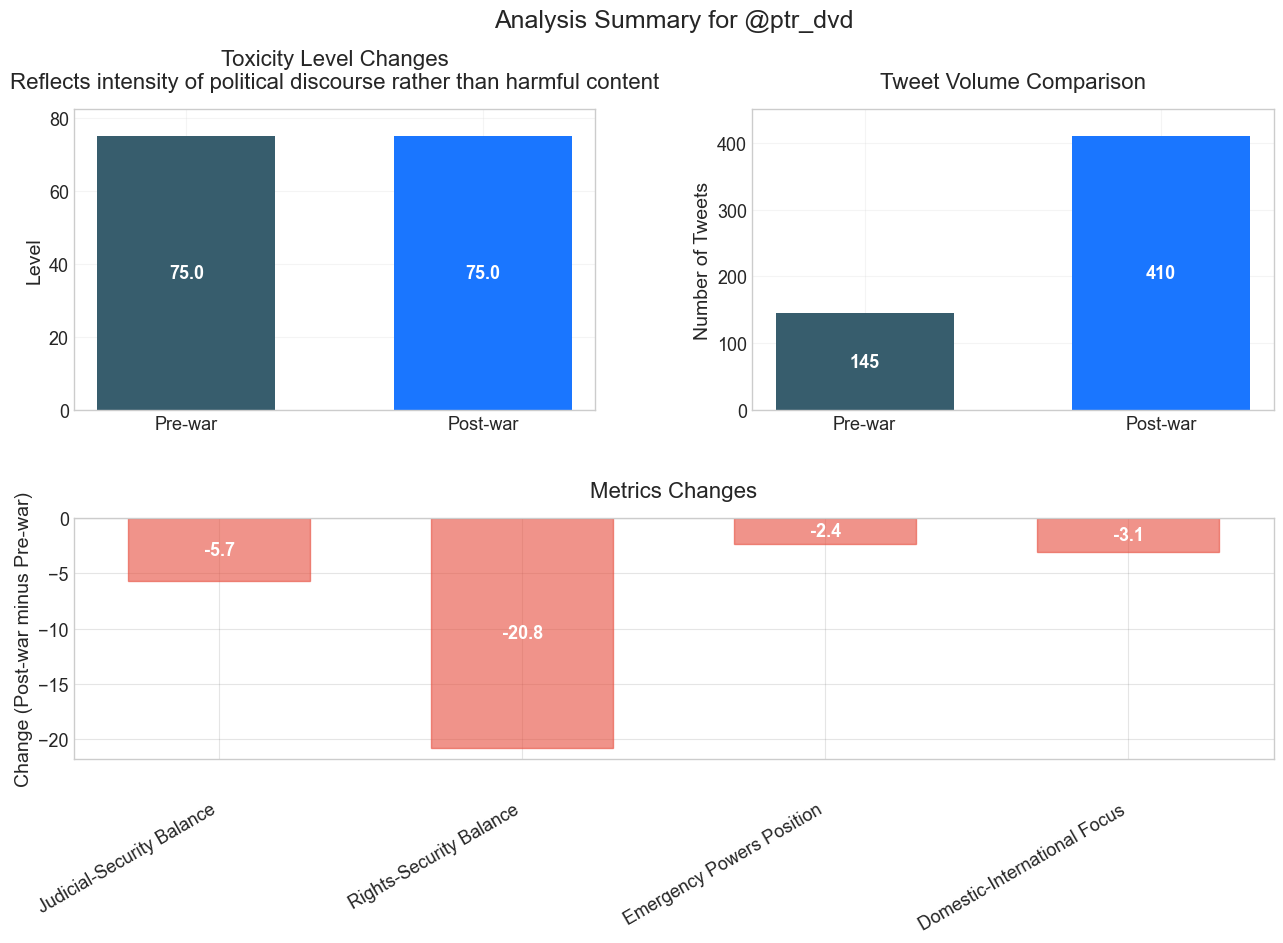

---

# User Analysis Report

## Analysis for @AmiadCohen

### Tweet Volume

- Pre-war tweets: 171
- Post-war tweets: 206
- Change: +35 (+20.5%)

### Most Intense Tweets

_Note: Content rated as moderately assertive pre-war and moderately assertive post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
הוא שלם עם זה שלנבחרי ציבור לא יהיה כח.
```

```
השמאל, התקשורת האקדמיה והפרקליטות עושים הכל כדי להוכיח שזה נכון.
```


**Post-war Period:**

```
בן גביר אדם נאלח, רדוד, פאשיסט, אלים וגזען. מה זה קשור?
```

```
לכבוש את כל השטח עד הליטאני, ולהודיע שאנחנו נשארים שם עד שחיזבאללה מפורק מנשקו.
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    75.0
Post-war:   55.9
Change:    -19.1
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    40.7
Post-war:   43.6
Change:     +2.9
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    75.0
Post-war:   71.1
Change:     -3.9
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    91.4
Post-war:   76.0
Change:    -15.4
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Judicial reform is critical for democracy

- Supreme Court undermines democratic processes

- Welfare state limits individual responsibility


**Post-war Top 3 Narratives:**

- Strengthen Israeli national security

- Judicial reform is necessary

- Free market economic principles


**Analysis of Changes:**

_The focus shifted from democratic processes, welfare, and judicial reform to national security, judicial reform, and free market principles in the post-war narratives._


### New Entities Criticized

- Ayman Barak

- Labor Unions


### No Longer Criticized

- Benny Gantz

- Yair Lapid

### Data Visualization


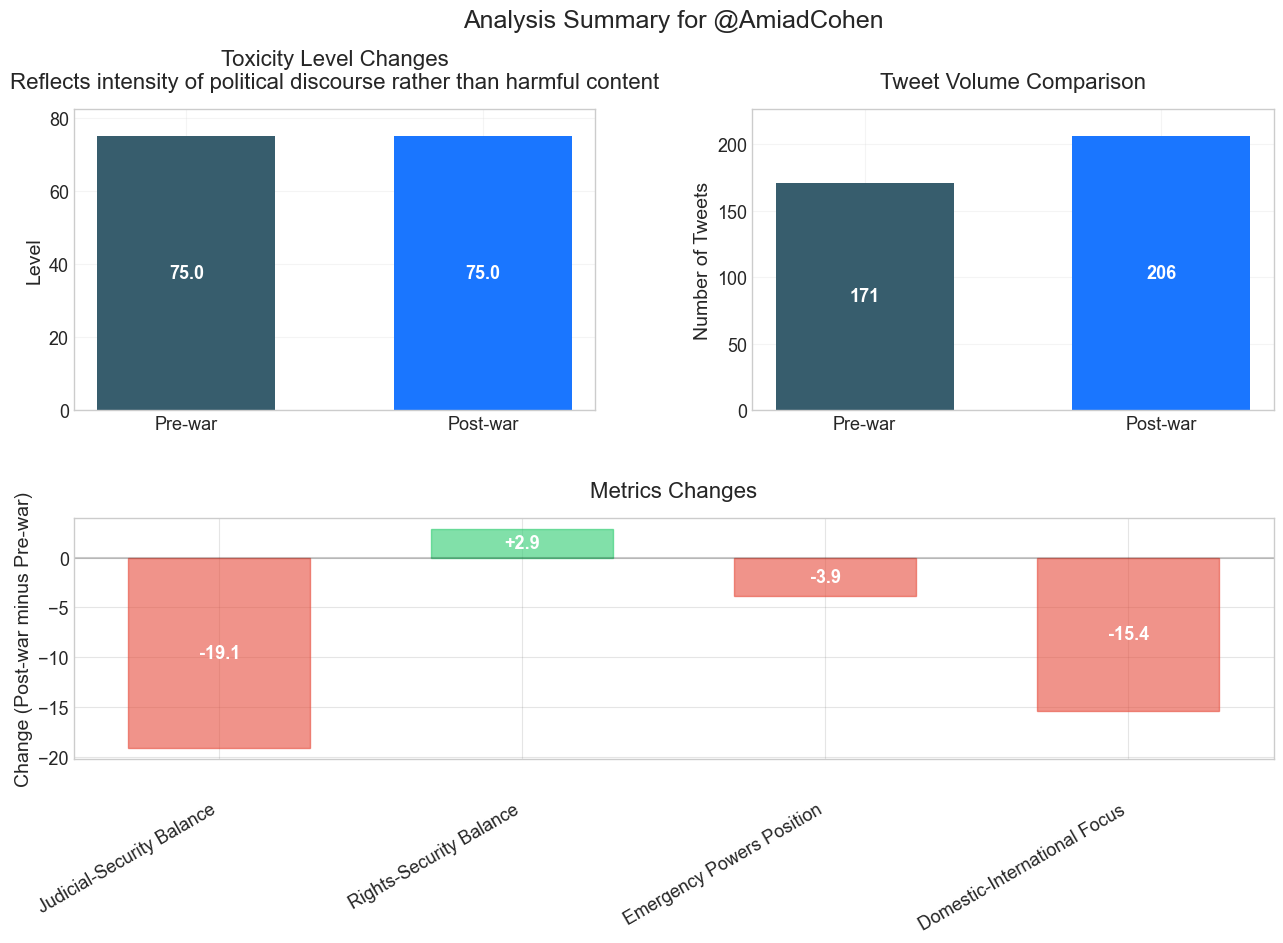

---

# User Analysis Report

## Analysis for @EVKontorovich

### Tweet Volume

- Pre-war tweets: 17
- Post-war tweets: 261
- Change: +244 (+1435.3%)

### Most Intense Tweets

_Note: Content rated as low toxicity pre-war and moderately assertive post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
הנשיאה של בית המשפט מנסה להפוך את עצמה לרשות בלתי מבוקרת מעל אפילו החוקים החוקתיים
```

```
הממשל של ביידן הופך לשותף בארגון UNESCO שמוחק יהודים מההיסטוריה
```


**Post-war Period:**

```
הבית הדין הפלילי הבינלאומי (ICC) הוכיח היום עד כמה הוא מוטה נגד ישראל
```

```
Dutch authorities must not only investigate the pogromnics in their metropolis, but also the inciter of blood libels in their capital - Karim Khan of the ICC.
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    85.0
Post-war:   37.1
Change:    -47.9
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    25.0
Post-war:   33.2
Change:     +8.2
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    75.0
Post-war:   71.8
Change:     -3.2
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    75.0
Post-war:   38.2
Change:    -36.8
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Judicial reform challenges Supreme Court power

- Palestinian historical narrative is manipulative

- Western institutions undermine Israeli interests


**Post-war Top 3 Narratives:**

- Defend Israel against international legal challenges

- Criticize Biden administration's Middle East policy

- Challenge international institutions' legitimacy


**Analysis of Changes:**

_The focus shifted from critiquing domestic and international institutions to defending Israel and challenging the legitimacy of international bodies and policies._


### New Entities Criticized

- ICC

- UNRWA


### No Longer Criticized

- Supreme Court of Israel

- UNESCO

### Data Visualization


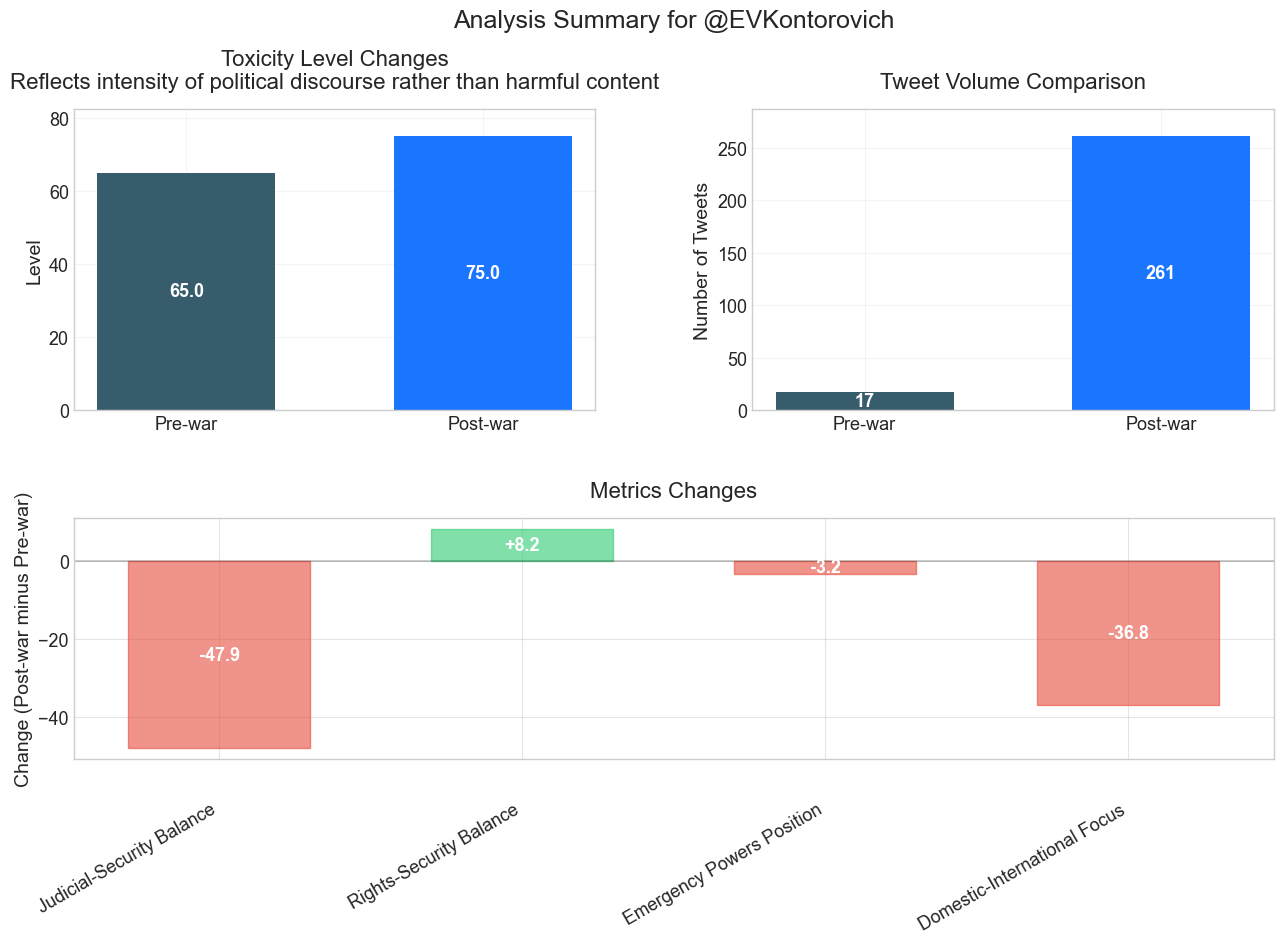

---

# User Analysis Report

## Analysis for @SagiBarmak

### Tweet Volume

- Pre-war tweets: 121
- Post-war tweets: 567
- Change: +446 (+368.6%)

### Most Intense Tweets

_Note: Content rated as moderately assertive pre-war and moderately assertive post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
למה רק לירוק? אולי נכה אותם? נגרש אותם מהארץ? נשעבד אותם?
```

```
תזכרו: הם לא מעוניינים בפלורליזם. הם לא רוצים שוק חופשי של רעיונות.
```


**Post-war Period:**

```
הייעוץ המשפטי נכשל. מה עושים עם פקידות כושלת?
```

```
הציבור הישראלי הורגל לחשוב שדוקטרינות רדיקליות הן בעצם נהגים סבירים ומקובלים.
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    81.7
Post-war:   69.2
Change:    -12.5
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    66.7
Post-war:   43.4
Change:    -23.3
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    72.0
Post-war:   72.8
Change:     +0.8
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    91.7
Post-war:   74.8
Change:    -16.9
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Judicial reform challenges existing power structures

- Supreme Court has excessive power

- Political elites manipulate democratic system


**Post-war Top 3 Narratives:**

- Judicial reform is necessary and legitimate

- Challenge liberal democratic institutions

- Defend Israeli national interests


**Analysis of Changes:**

_The focus shifted from criticizing the judicial system and political elites to defending national interests and challenging liberal democratic institutions in the post-war narratives._


### New Entities Criticized

- Kamala Harris

- Supreme Court Legal Advisors


### No Longer Criticized

- Tzipi Livni

- Esther Hayut

### Data Visualization


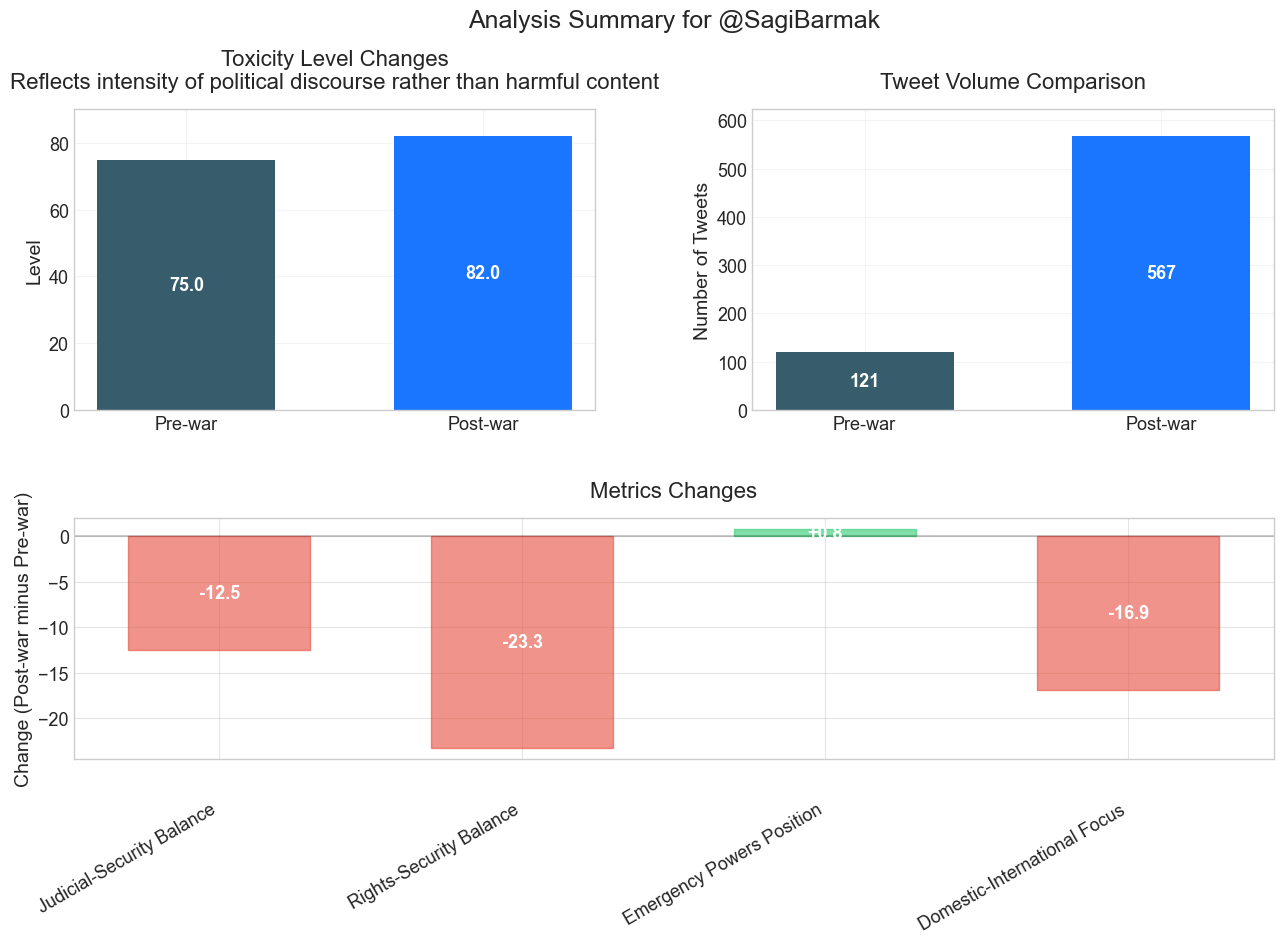

---

# User Analysis Report

## Analysis for @KoheletForum

### Tweet Volume

- Pre-war tweets: 70
- Post-war tweets: 95
- Change: +25 (+35.7%)

### Most Intense Tweets

_Note: Content rated as low toxicity pre-war and low toxicity post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
לצערנו, גבולות ההסתה נחצים פעם אחר פעם ללא מענה ממשי.
```

```
לפרסם שקרים, העיקר להשחיר את מי שלא בדיוק בדעות שלו
```


**Post-war Period:**

```
בית הדין הפלילי הבינלאומי (ICC) הוכיח היום עד כמה הוא מוטה נגד ישראל
```

```
סוכנות אונר
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    75.0
Post-war:   42.5
Change:    -32.5
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    50.0
Post-war:   32.5
Change:    -17.5
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    75.0
Post-war:   75.0
Change:     +0.0
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    87.4
Post-war:   47.5
Change:    -39.9
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Judicial reform challenges Israeli democratic institutions

- Limit Supreme Court's power

- Free market principles should guide policy


**Post-war Top 3 Narratives:**

- Expose international organizations' anti-Israel bias

- Challenge legal institutions targeting Israel

- Defend Israeli state sovereignty


**Analysis of Changes:**

_The focus shifted from domestic judicial reform to defending Israel's sovereignty and challenging international institutions perceived as biased against Israel._


### New Entities Criticized

- ICC

- UNRWA

- Francesca Albanese


### No Longer Criticized

- Supreme Court

- Benny Gantz

- Aharon Barak

### Data Visualization


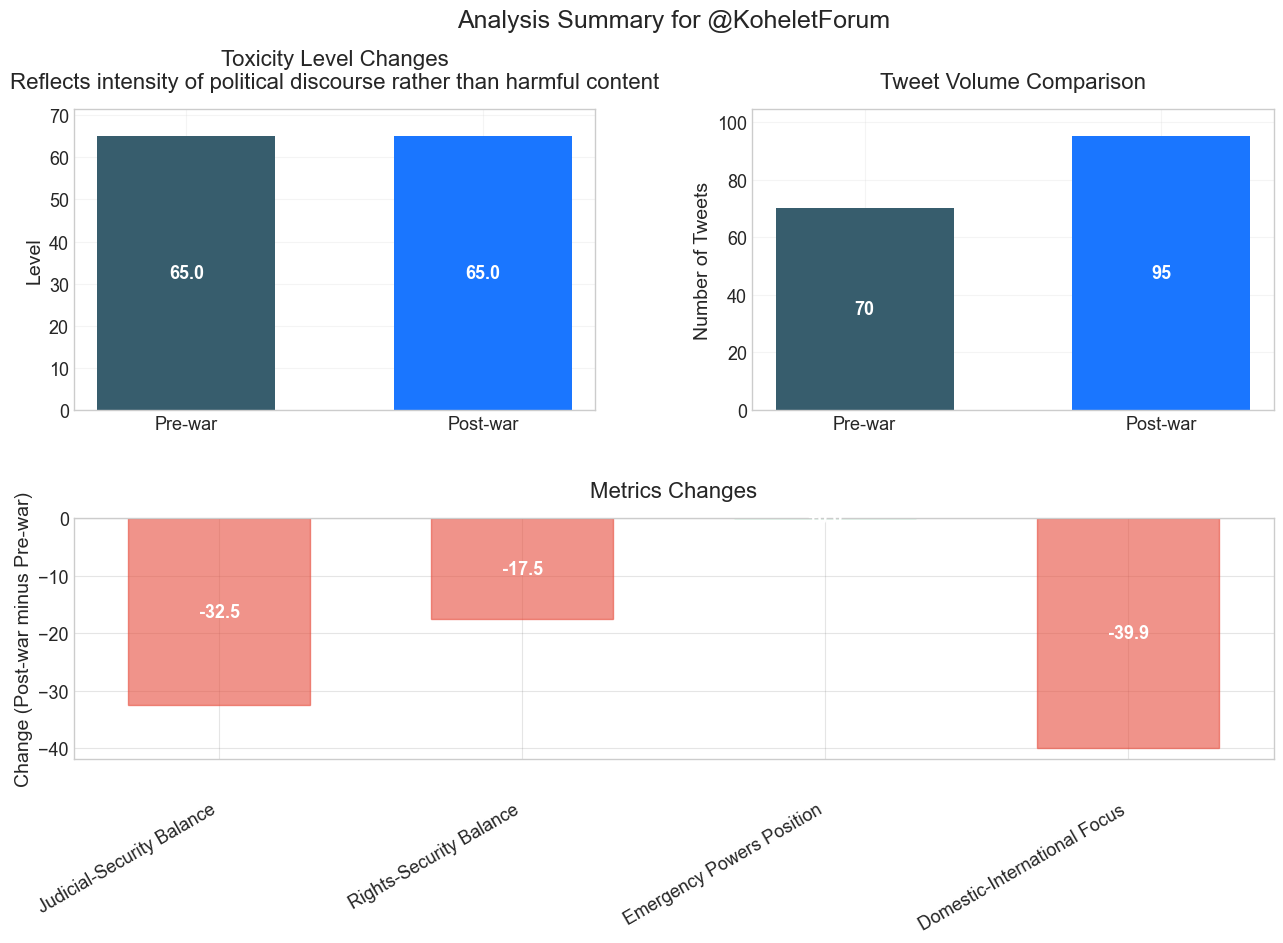

---

# User Analysis Report

## Analysis for @rotem_sella

### Tweet Volume

- Pre-war tweets: 300
- Post-war tweets: 182
- Change: -118 (-39.3%)

### Most Intense Tweets

_Note: Content rated as moderately assertive pre-war and moderately assertive post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
אבו מאזן הוא אנטישמי מקצועי. זו אשכרה ההתמחות המקצועית שלו.
```

```
פאשיסט, עצוב שבריונים כמותו משמשים בתפקיד במוסד ציבורי.
```


**Post-war Period:**

```
הם יורים בהם כמו בחולדות אם הם מנסים לברוח מהגיהינום הזה.
```

```
אם הסקרים היו משקפים את עמדת הציבור, היינו היום בממשלת גנץ השלישית או בממשלת לפיד השנייה
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    78.5
Post-war:   62.5
Change:    -16.0
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    48.4
Post-war:   46.2
Change:     -2.2
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    71.2
Post-war:   72.4
Change:     +1.2
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    89.3
Post-war:   76.2
Change:    -13.0
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Judicial reform challenging existing power structures

- Media manipulation and political control

- Protecting Jewish national character


**Post-war Top 3 Narratives:**

- Netanyahu's legal battle dominates political discourse

- Trump's return will transform global politics

- Critique of Israeli government economic policies


**Analysis of Changes:**

_The focus shifted from systemic issues like power structures, media control, and national identity to specific political figures and their legal/economic policies._


### New Entities Criticized

- Joe Biden


### No Longer Criticized

- Supreme Court

### Data Visualization


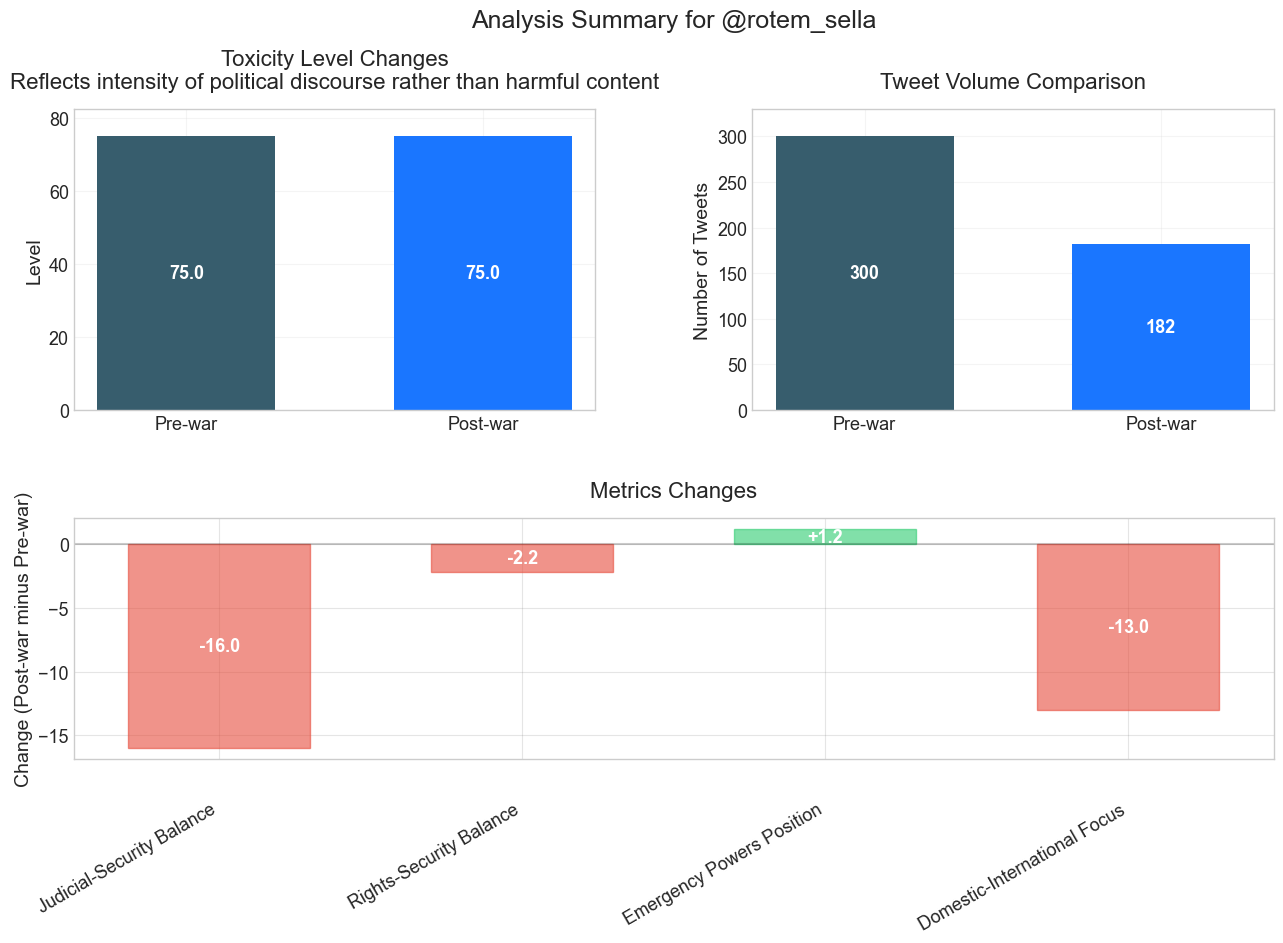

---

# User Analysis Report

## Analysis for @ShimonNataf

### Tweet Volume

- Pre-war tweets: 133
- Post-war tweets: 2,118
- Change: +1,985 (+1492.5%)

### Most Intense Tweets

_Note: Content rated as moderately assertive pre-war and moderately assertive post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
המעבר של המחאה ל-BDS מובהק ובוטה החותר תחת האינטרסים הבסיסיים ביותר של ישראל כמדינה
```

```
מה שכל כך מדכא זה שהשופטים יכולים לסיים את סאגת הרפורמה כולה, בהינף מקלדת
```


**Post-war Period:**

```
מיעוט קטן ובזוי. מקומך בכלא. לפחות תעמוד מאחורי הבחירות הגרועות שלך בחיים.
```

```
חח.טרנספר של אוכלוסיה אנטישמו-חמאסית הוא רעיון מוסרי לעילא. השאלה היחידה היא פרקטית.
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    78.4
Post-war:   72.2
Change:     -6.2
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    32.6
Post-war:   43.8
Change:    +11.1
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    58.3
Post-war:   71.9
Change:    +13.5
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    91.7
Post-war:   84.9
Change:     -6.8
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Judicial reform is essential for democracy

- Supreme Court lacks legitimate authority

- Political system needs fundamental restructuring


**Post-war Top 3 Narratives:**

- Judicial reform challenges Israeli democratic institutions

- Political system deeply polarized

- Supreme Court has excessive political power


**Analysis of Changes:**

_The focus shifted from advocating for judicial reform and political restructuring to criticizing the Supreme Court's political influence and the deep polarization within the political system._


### New Entities Criticized

- Benny Gantz

- Yair Lapid


### No Longer Criticized

- Aharon Barak

- Esther Hayut

### Data Visualization


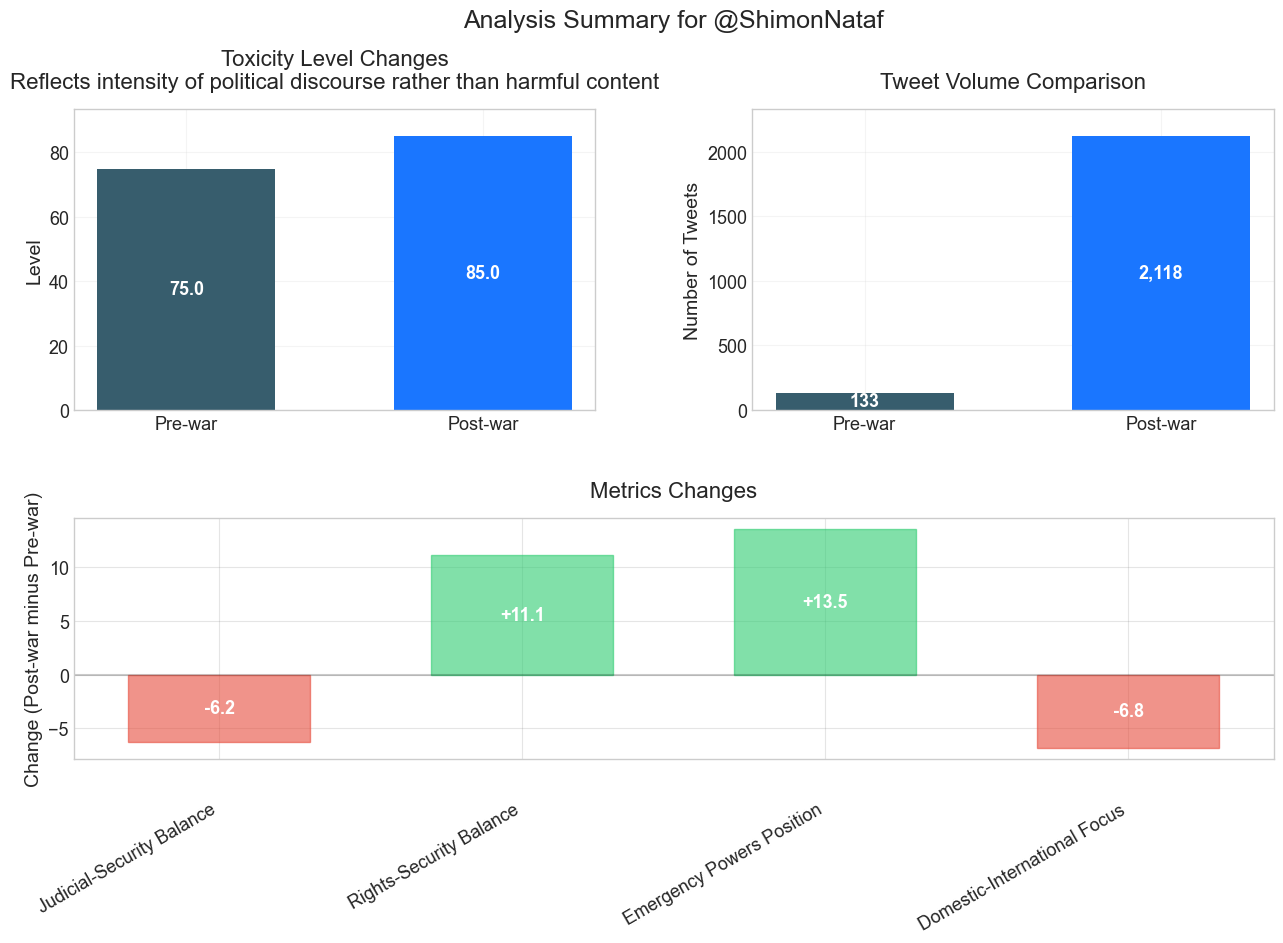

---

# User Analysis Report

## Analysis for @russell_sl

### Tweet Volume

- Pre-war tweets: 300
- Post-war tweets: 89
- Change: -211 (-70.3%)

### Most Intense Tweets

_Note: Content rated as moderately assertive pre-war and moderately assertive post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
השופטים אומרים שצריך לקיים חוקים רק כשהם נוחים להם.
```

```
מי? מי פועל באופן רציני כדי להמליך את בן דוד, להחזיר ד׳ מיתות בית דין, להקים משטרת צניעות
```


**Post-war Period:**

```
אחרי שבני דודים של אשתי נפצעו קשה בפיגוע, גדעון לוי כתב: אשה הרה נפצעת, ולדה מת מפצעיהו
```

```
אנטישמיות!!! הנאצים בדיוק רצו שיהודים יתגייסו לצבא של המדינה היהודית!
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    81.8
Post-war:   65.0
Change:    -16.8
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    51.4
Post-war:   35.0
Change:    -16.4
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    73.3
Post-war:   75.0
Change:     +1.7
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    90.9
Post-war:   57.5
Change:    -33.4
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Judicial reform strengthens Israeli democracy

- Supreme Court has excessive unaccountable power

- Democratic processes need fundamental restructuring


**Post-war Top 3 Narratives:**

- Israel's legal right to self-defense

- Challenge international institutional bias

- Jewish historical territorial legitimacy


**Analysis of Changes:**

_The focus shifted from domestic judicial reform to emphasizing Israel's legal right to self-defense and challenging perceived international bias against Jewish historical territorial claims._


### New Entities Criticized

- UNRWA

- Hezbollah

- Hamas


### No Longer Criticized

- Supreme Court

- Aharon Barak

- Yair Lapid

### Data Visualization


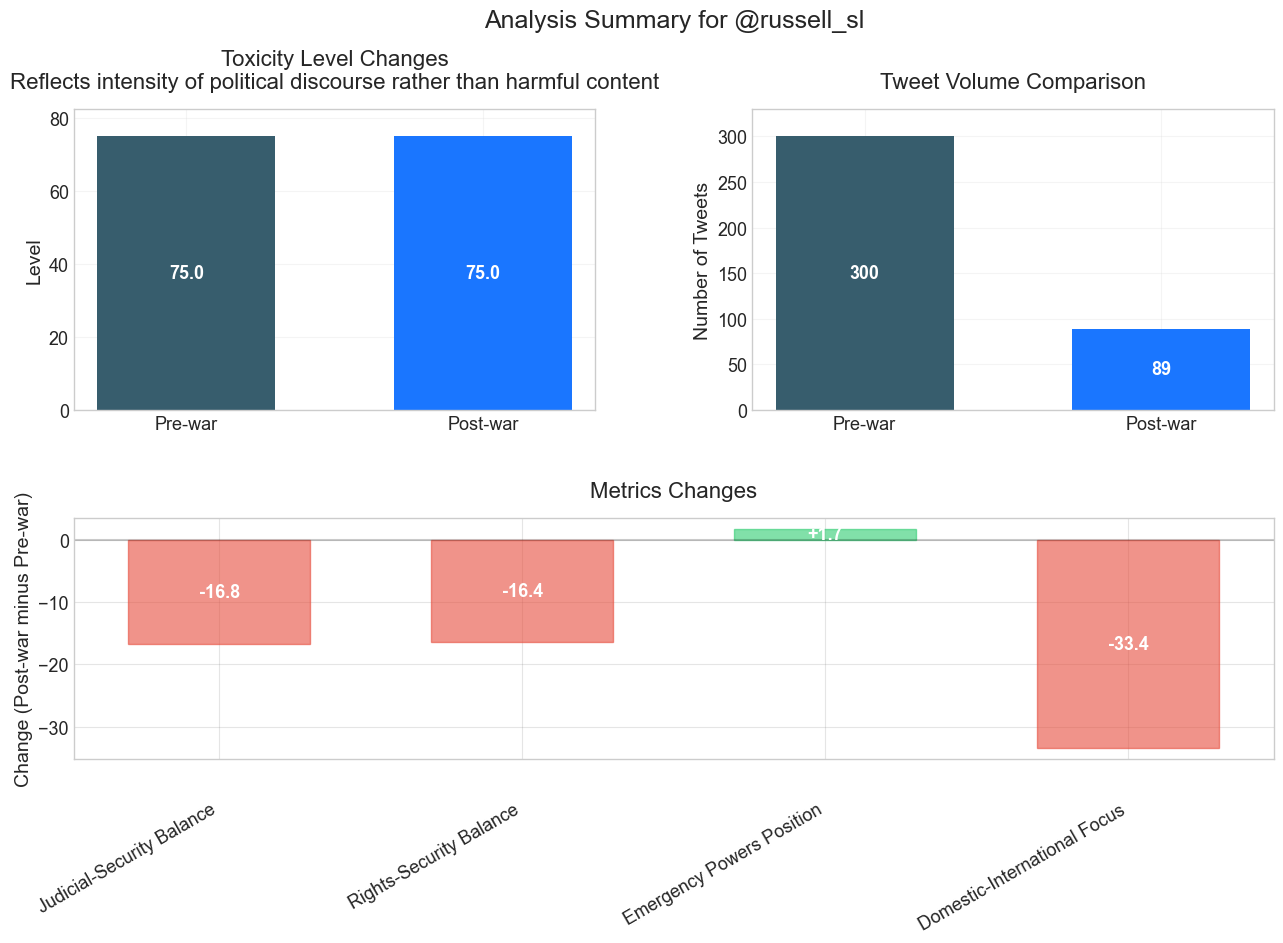

---

# User Analysis Report

## Analysis for @MalkaElad

### Tweet Volume

- Pre-war tweets: 34
- Post-war tweets: 886
- Change: +852 (+2505.9%)

### Most Intense Tweets

_Note: Content rated as low toxicity pre-war and moderately assertive post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
כתבה כל כך אורווליאנית. מעבירים חוק שכל תכליתו היא פחות מעורבות ממשלתית ופוליטית בתקשורת והיא אומרת הפוך.
```

```
וזה כמובן חוץ מהעובדה הפשוטה שהרגולטור הנוכחי קובי מי יקבל רישיון חדשות והאם הוא מדווח כמו שצריך
```


**Post-war Period:**

```
לכלא, אחד אחרי השני. בלי למצמץ, בלי לגמגם ובהליך פלילי על כל המשתמע ממנו.
```

```
לא משנה מה דעתכם על נתניהו, התגובה למדינה שניסתה לאיים על חיי ראש ממשלת ישראל צריכה להיות אחת: חיסול מנהיג המדינה.
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    75.0
Post-war:   53.1
Change:    -21.9
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    75.0
Post-war:   42.9
Change:    -32.1
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    50.0
Post-war:   70.5
Change:    +20.5
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    85.0
Post-war:   80.7
Change:     -4.3
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Reduce political influence in media regulation

- Open news market to competition

- Challenge existing media power structures


**Post-war Top 3 Narratives:**

- Judicial reform and political transformation

- Military service draft controversy

- Israel's national security strategy


**Analysis of Changes:**

_The focus shifted from media regulation and competition to judicial reform, military service, and national security, reflecting a transition from domestic to geopolitical priorities._


### New Entities Criticized

- Netanyahu

- Benny Gantz

- Yair Lapid


### No Longer Criticized

- Ministry of Communication

- N12 News Channel

- Current Media Regulator

### Data Visualization


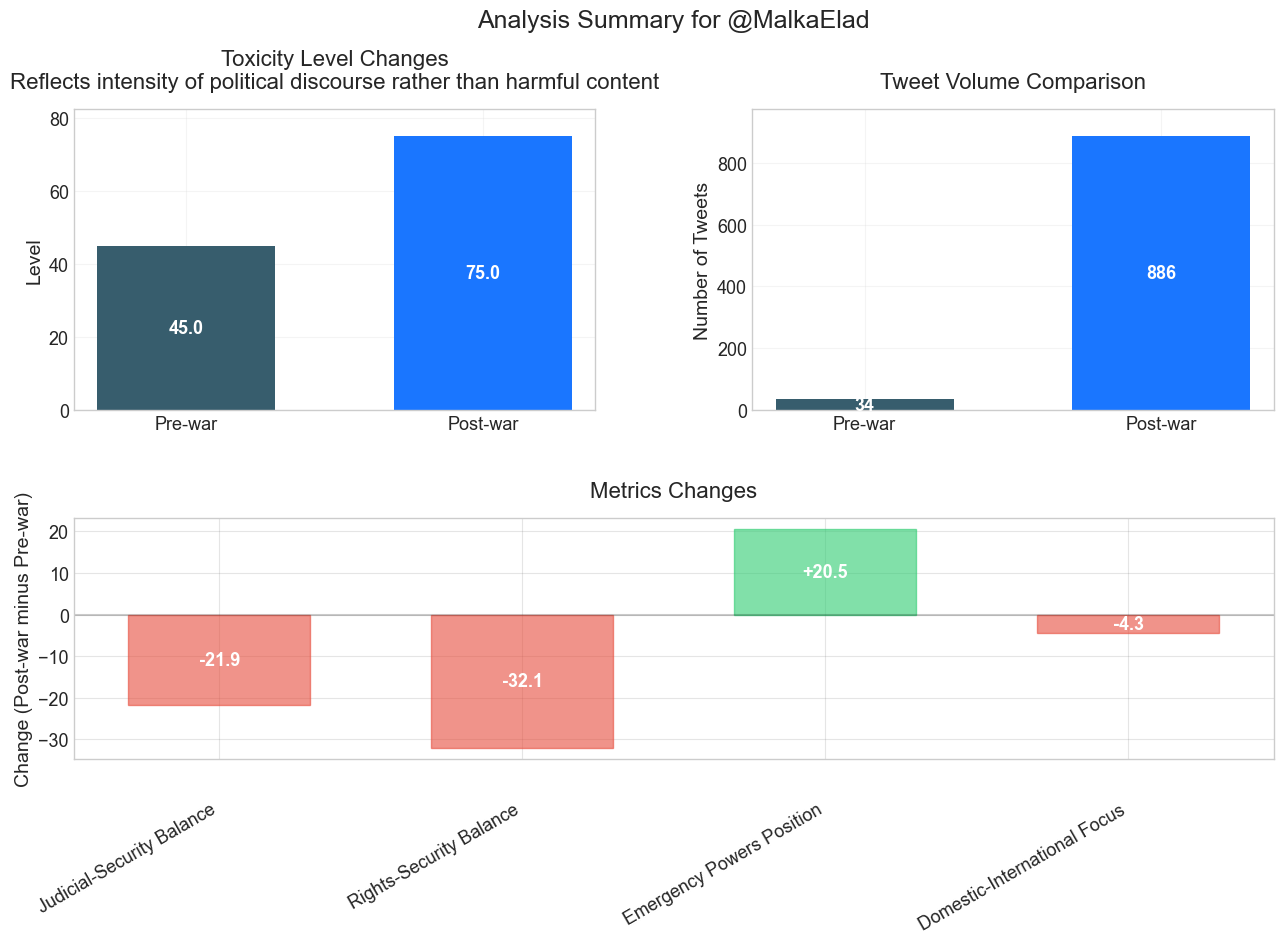

---

# User Analysis Report

## Analysis for @SaraHaetzniCohe

### Tweet Volume

- Pre-war tweets: 60
- Post-war tweets: 537
- Change: +477 (+795.0%)

### Most Intense Tweets

_Note: Content rated as moderately assertive pre-war and moderately assertive post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
שמחתי לעזור. בברכת דמו-קר-טיה להמונים
```

```
הרווחה לא לוקחת לכם את הילדים כי אף אחד לא יירצה אותם
```


**Post-war Period:**

```
וואלה לא, ונשבר לי. הוא יודע יפה מאד מי מונע את האוכל מהעזתים
```

```
קלאסי בעל מתעלל. אני נועל אותך בבית לטובתך
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    50.0
Post-war:   41.4
Change:     -8.6
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    37.1
Post-war:   31.1
Change:     -6.0
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    75.0
Post-war:   75.0
Change:     +0.0
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    87.5
Post-war:   81.8
Change:     -5.7
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Judicial reform creates deep societal divisions

- Challenging military and political elite resistance

- Defending nationalist political transformation


**Post-war Top 3 Narratives:**

- Support for Israeli military and reservists

- Defend national security narrative

- Criticize media and judicial establishment


**Analysis of Changes:**

_The focus shifted from political and judicial reform to supporting the military, national security, and criticizing the media and judicial establishment in the post-war narratives._


### New Entities Criticized

- Ilana Dayan

- Hamas


### No Longer Criticized

- Guy Rolnik

- Amos Yadlin

### Data Visualization


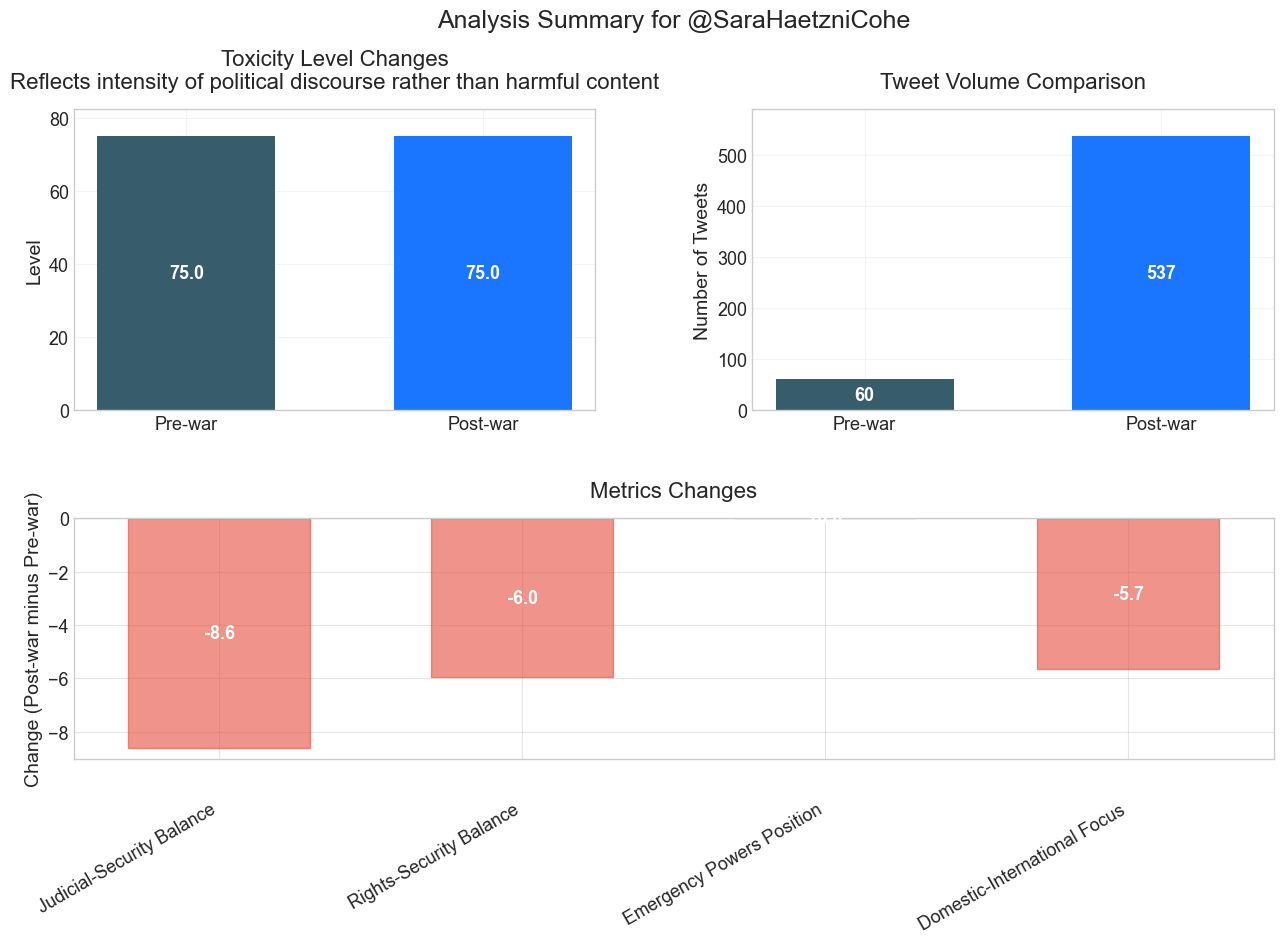

---

# User Analysis Report

## Analysis for @berale_crombie

### Tweet Volume

- Pre-war tweets: 72
- Post-war tweets: 555
- Change: +483 (+670.8%)

### Most Intense Tweets

_Note: Content rated as moderately assertive pre-war and moderately assertive post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
מדינה שבה קציני הצבא מארגנים מרד נגד הממשלה שנבחרה ברוב דמוקרטי - היא מדינה שמתרחשת בה הפיכה צבאית
```

```
הבריונות של השמאל מנסה לפגוע בכל מי שהוא לא הם.
```


**Post-war Period:**

```
שלום השופט שטיין, הלילה כשתישן טוב במיטה המחוממת שלך, אחרי כוס ויסקי וארוחה טובה, תזכור שבאותו זמן שני חיילים מצטיינים ישנו בקור בבית כלא על מיטה מעופשת, מוקפים בפושעים, רק כי לך ״לא היה מספיק זמן ללמוד את החומר״. זוהי סדום!
```

```
אתה פסיכופת, מניאק מסוכן, אדם חולה שיפסיד כי ההיגיון, הדמוקרטיה והחופש ינצחו ותמיד נתמוך בישראל.
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    75.0
Post-war:   50.5
Change:    -24.5
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    25.0
Post-war:   37.4
Change:    +12.4
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    75.0
Post-war:   72.1
Change:     -2.9
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    87.5
Post-war:   88.4
Change:     +0.9
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Judicial reform is crucial for democracy

- Left wing threatens national unity

- Right wing must defend principles


**Post-war Top 3 Narratives:**

- Judicial reform and political persecution

- Haredi draft resistance undermines national security

- Defend Israel against perceived enemies


**Analysis of Changes:**

_The focus shifted from broad political and ideological debates to more specific issues of judicial reform, national security, and perceived threats, reflecting the impact of the war._


### New Entities Criticized

- Benny Gantz


### No Longer Criticized

- Ehud Barak

### Data Visualization


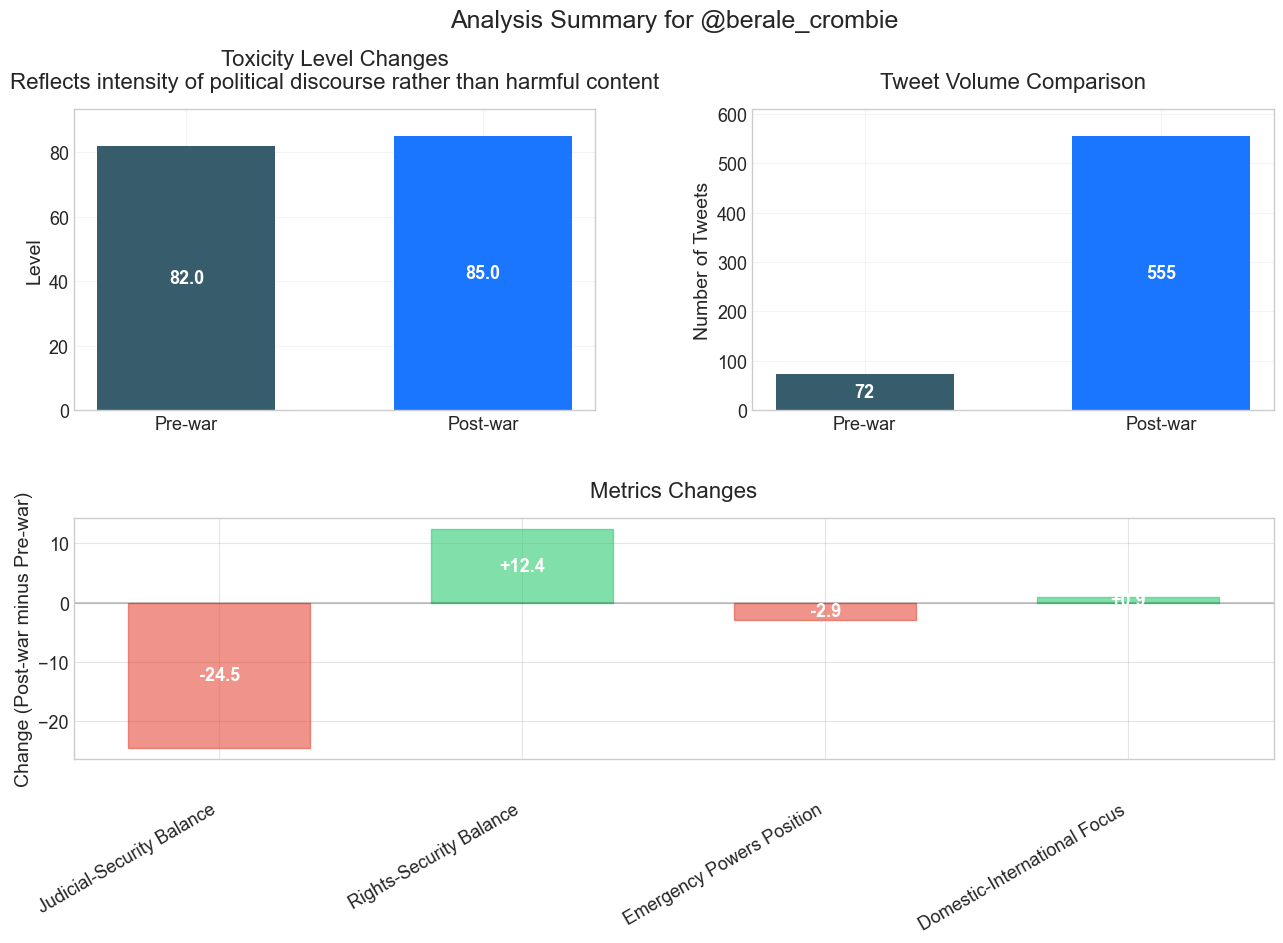

---

No data found for user Argaman_Inst


# User Analysis Report

## Analysis for @ShovalRonen

### Tweet Volume

- Pre-war tweets: 20
- Post-war tweets: 792
- Change: +772 (+3860.0%)

### Most Intense Tweets

_Note: Content rated as moderately assertive pre-war and moderately assertive post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
האלימות היא כרסום יסוד הדמוקרטיה
```

```
הארץ מודה - זו הפיכה צבאית
```


**Post-war Period:**

```
מה שצריך לעשות הערב זה להעמיס את החמולה של המחבלים מחברון על רכבים, ולפרוק אותם בעזה. ואז לפוצץ את הבתים שלהם.
```

```
נְקָמָה כָזֹאת, נִקְמַת דַּם יֶלֶד קָטָן עוֹד לֹא-בָרָא הַשָּׂטָן
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    75.0
Post-war:   64.8
Change:    -10.2
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    50.0
Post-war:   33.5
Change:    -16.5
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    75.0
Post-war:   75.0
Change:     +0.0
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    90.0
Post-war:   84.4
Change:     -5.6
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Judicial reform is necessary for democracy

- Left wing threatens Israeli political stability

- Political system lacks genuine representation


**Post-war Top 3 Narratives:**

- Judicial system undermines democratic principles

- Right-wing reform needed for national progress

- Israel faces external and internal threats


**Analysis of Changes:**

_The narratives shifted from emphasizing judicial reform, left-wing threats, and lack of representation to criticizing the judicial system, advocating right-wing reform, and highlighting external and internal threats to Israel._


### New Entities Criticized

- Haaretz newspaper

- Yair Lapid


### No Longer Criticized

- Ehud Barak

- Palestinian Authority

### Data Visualization


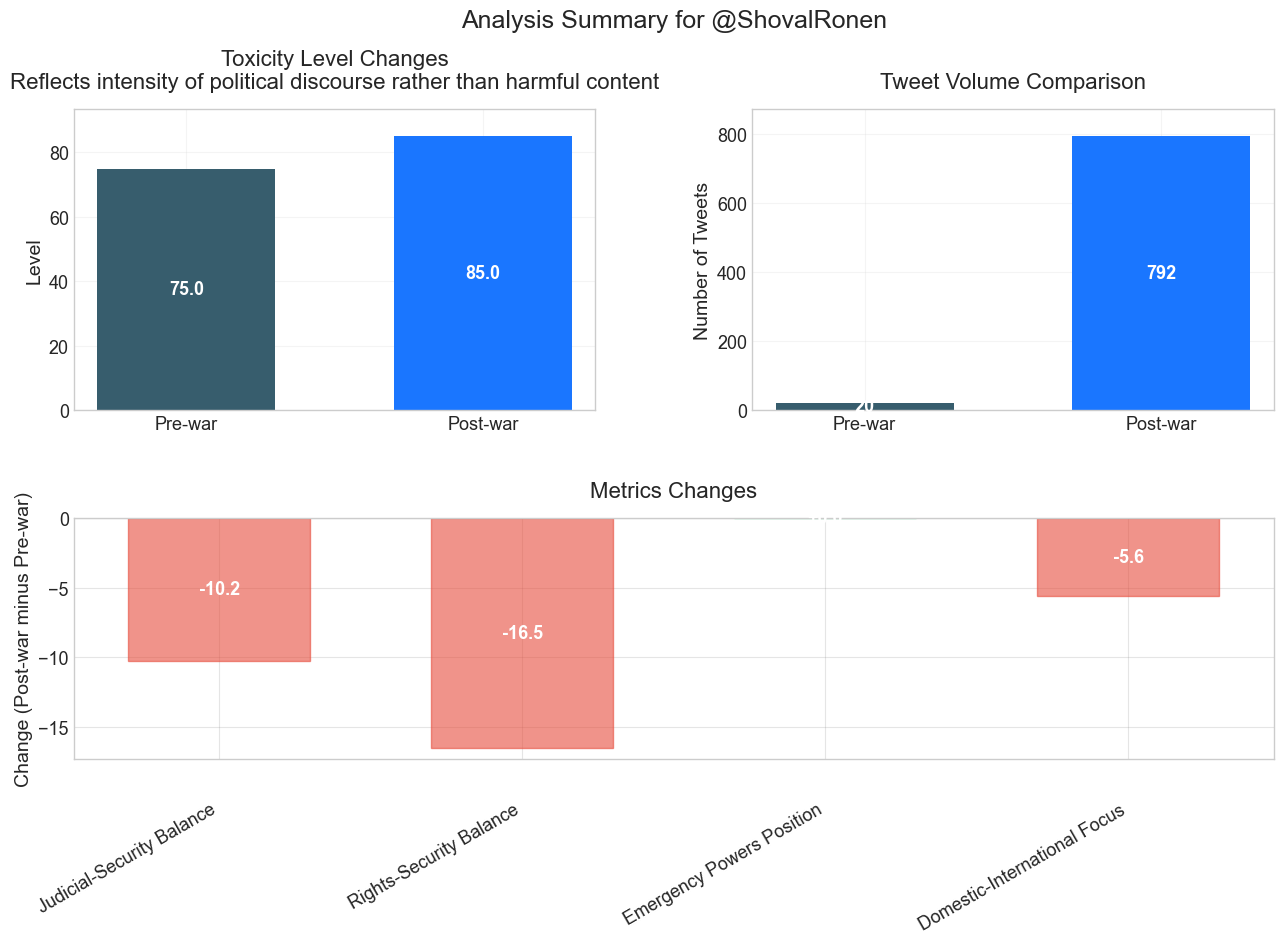

---

# User Analysis Report

## Analysis for @Shauli_Sharf

### Tweet Volume

- Pre-war tweets: 6
- Post-war tweets: 3
- Change: -3 (-50.0%)

### Most Intense Tweets

_Note: Content rated as low toxicity pre-war and low toxicity post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
השופטים אינם טובים או רעים - הם רק בני אדם.
```

```
מעין סיכום ביניים למערבולת בה נמצא בית המשפט העליון
```


**Post-war Period:**

```
No toxic content identified
```

```
No toxic content identified
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    85.0
Post-war:   25.0
Change:    -60.0
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    75.0
Post-war:   25.0
Change:    -50.0
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    50.0
Post-war:   50.0
Change:     +0.0
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    95.0
Post-war:   75.0
Change:    -20.0
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Judicial reform needs transparency

- Supreme Court facing critical changes

- Political neutrality in legal system


**Post-war Top 3 Narratives:**

- No clear narrative identified


**Analysis of Changes:**

_The pre-war narratives focused on judicial reform, Supreme Court changes, and political neutrality in the legal system. In contrast, the post-war narratives lacked a clear narrative, suggesting a shift in priorities and themes._


### New Entities Criticized

- No specific entities identified


### No Longer Criticized

- Supreme Court judges

- Current judicial system

### Data Visualization


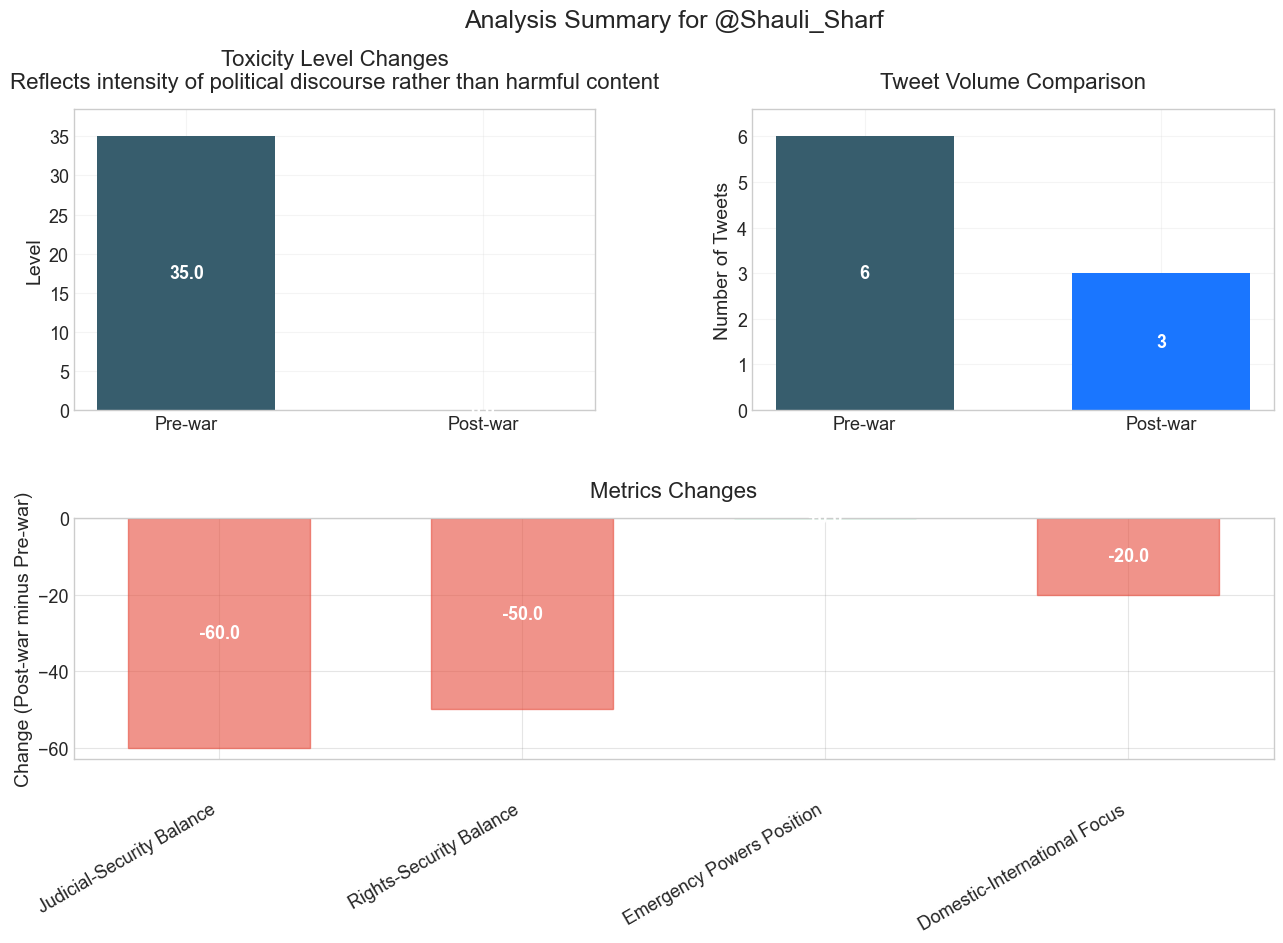

---

# User Analysis Report

## Analysis for @DBortnovskiy

### Tweet Volume

- Pre-war tweets: 6
- Post-war tweets: 1
- Change: -5 (-83.3%)

### Most Intense Tweets

_Note: Content rated as low toxicity pre-war and low toxicity post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
תתחילו לקרוא דברים רציניים ולענות להם בצורה עניינית. כל הטבלאות הדמגוגיות האלה מגוכחות ברמות
```

```
אוף הלוואי שבאמת היית כותבת בהתאם לדגל ששמת כאן
```


**Post-war Period:**

```
הקטע עם אוקראינה פשוט לא מגובה עובדתית, הוא עזר להם והרבה
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    75.0
Post-war:   50.0
Change:    -25.0
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    50.0
Post-war:   50.0
Change:     +0.0
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    50.0
Post-war:   50.0
Change:     +0.0
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:   100.0
Post-war:   25.0
Change:    -75.0
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Challenge intellectual assumptions

- Defend democratic process

- Critique protest rhetoric


**Post-war Top 3 Narratives:**

- Ukraine support lacks factual basis

- Criticism of external assistance

- Questioning humanitarian intervention strategies


**Analysis of Changes:**

_The narratives shifted from defending democracy and critiquing protest to questioning the factual basis and strategies behind Ukraine support and humanitarian intervention after the war._


### New Entities Criticized

- Ukraine support networks

### Data Visualization


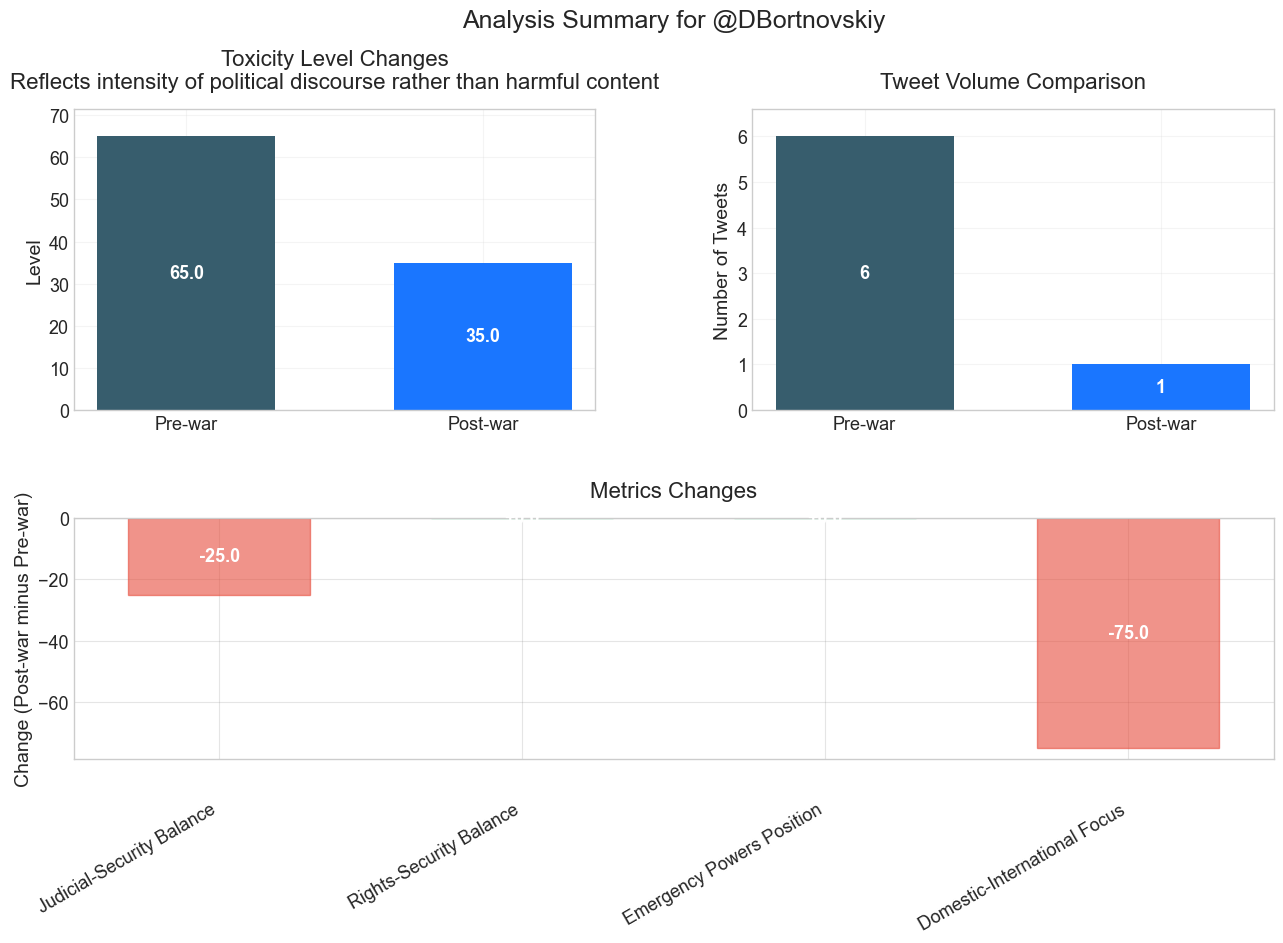

---

# User Analysis Report

## Analysis for @hashiloach

### Tweet Volume

- Pre-war tweets: 6
- Post-war tweets: 12
- Change: +6 (+100.0%)

### Most Intense Tweets

_Note: Content rated as low toxicity pre-war and low toxicity post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
No toxic content identified
```

```
No toxic content identified
```


**Post-war Period:**

```
האם התערבות שיפוטית בנושאי ביטחון היא לגיטימית בדמוקרטיה הנלחמת?
```

```
שירתָּ – קיבלת; לא שירתָּ – לא קיבלת
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    75.0
Post-war:   75.0
Change:     +0.0
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    75.0
Post-war:   25.0
Change:    -50.0
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    50.0
Post-war:   75.0
Change:    +25.0
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    75.0
Post-war:   75.0
Change:     +0.0
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- No clear narrative identified


**Post-war Top 3 Narratives:**

- Judicial reform is necessary for national security

- Military service should determine social benefits

- Israel must achieve total victory in conflict


**Analysis of Changes:**

_The pre-war narratives lacked a clear focus, while the post-war narratives emphasized judicial reform for national security, military service determining social benefits, and the pursuit of total victory in the conflict._


### New Entities Criticized

- Supreme Court (בג"ץ)

- Mike Huckabee

- Biden Administration


### No Longer Criticized

- No specific entities identified

### Data Visualization


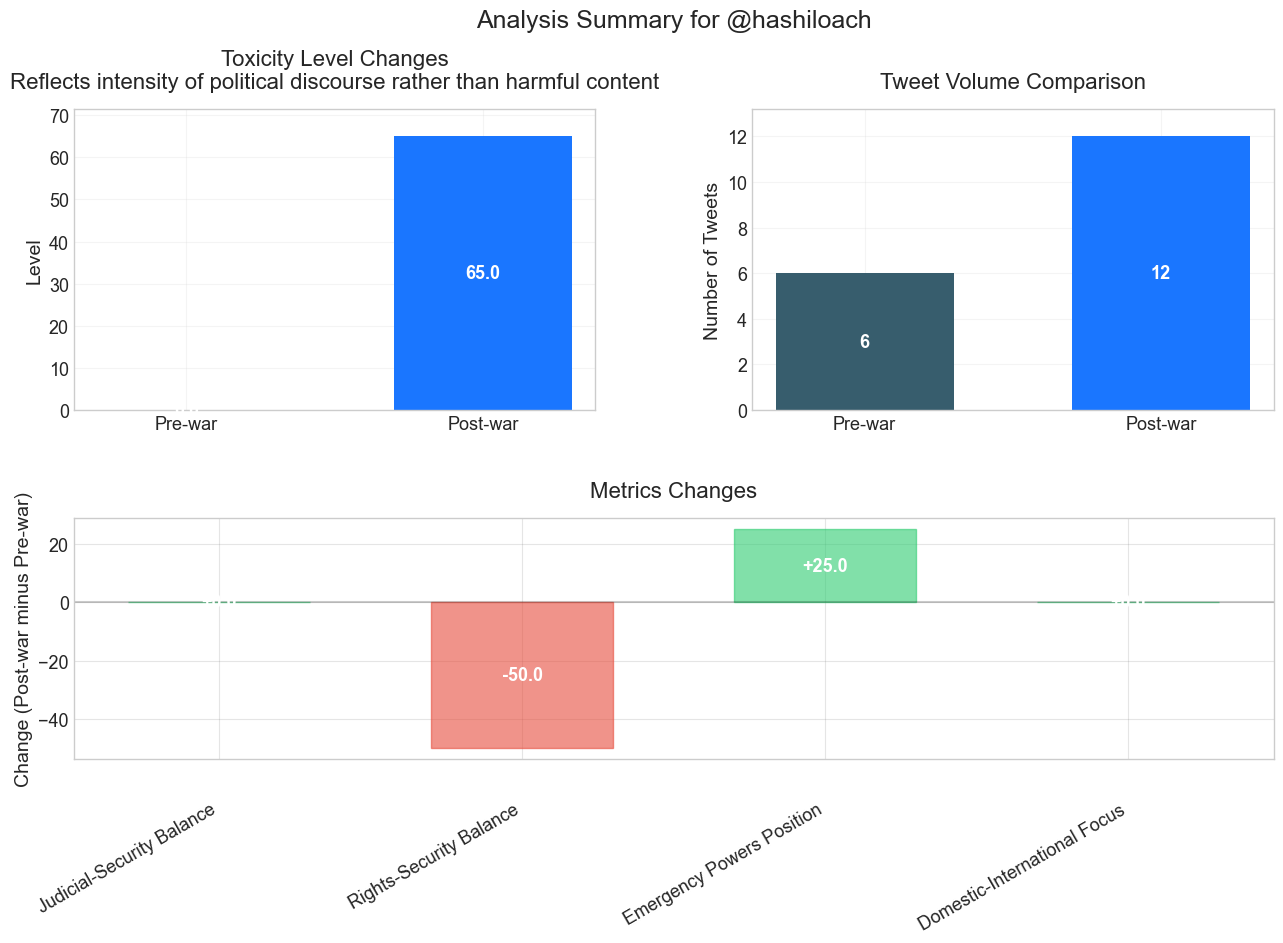

---

# User Analysis Report

## Analysis for @SellaMeirPress

### Tweet Volume

- Pre-war tweets: 24
- Post-war tweets: 44
- Change: +20 (+83.3%)

### Most Intense Tweets

_Note: Content rated as low toxicity pre-war and low toxicity post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
No toxic content identified
```

```
No toxic content identified
```


**Post-war Period:**

```
צעירי המערב איבדו כיוון והפכו טפילים. על ההורים, על המדינה ועל עתיד האנושות.
```

```
רוח בלהות מנשבת באמריקה. סטודנטים שמתבצרים בקמפוסים של אוניברסיטאות העילית, אנרכיה ברחובות
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    75.0
Post-war:   25.0
Change:    -50.0
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    25.0
Post-war:   25.0
Change:     +0.0
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    75.0
Post-war:   75.0
Change:     +0.0
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    90.0
Post-war:   50.0
Change:    -40.0
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- No clear narrative identified


**Post-war Top 3 Narratives:**

- Western civilization under ideological attack

- Israeli patriotic publishing movement emerging

- Defending traditional values through literature


**Analysis of Changes:**

_The focus shifted from a lack of clear narratives pre-war to post-war narratives emphasizing the defense of Western civilization, Israeli patriotism, and traditional values through literature._


### New Entities Criticized

- Ben Shapiro

- Progressive academia

- Woke culture


### No Longer Criticized

- No specific entities identified

### Data Visualization


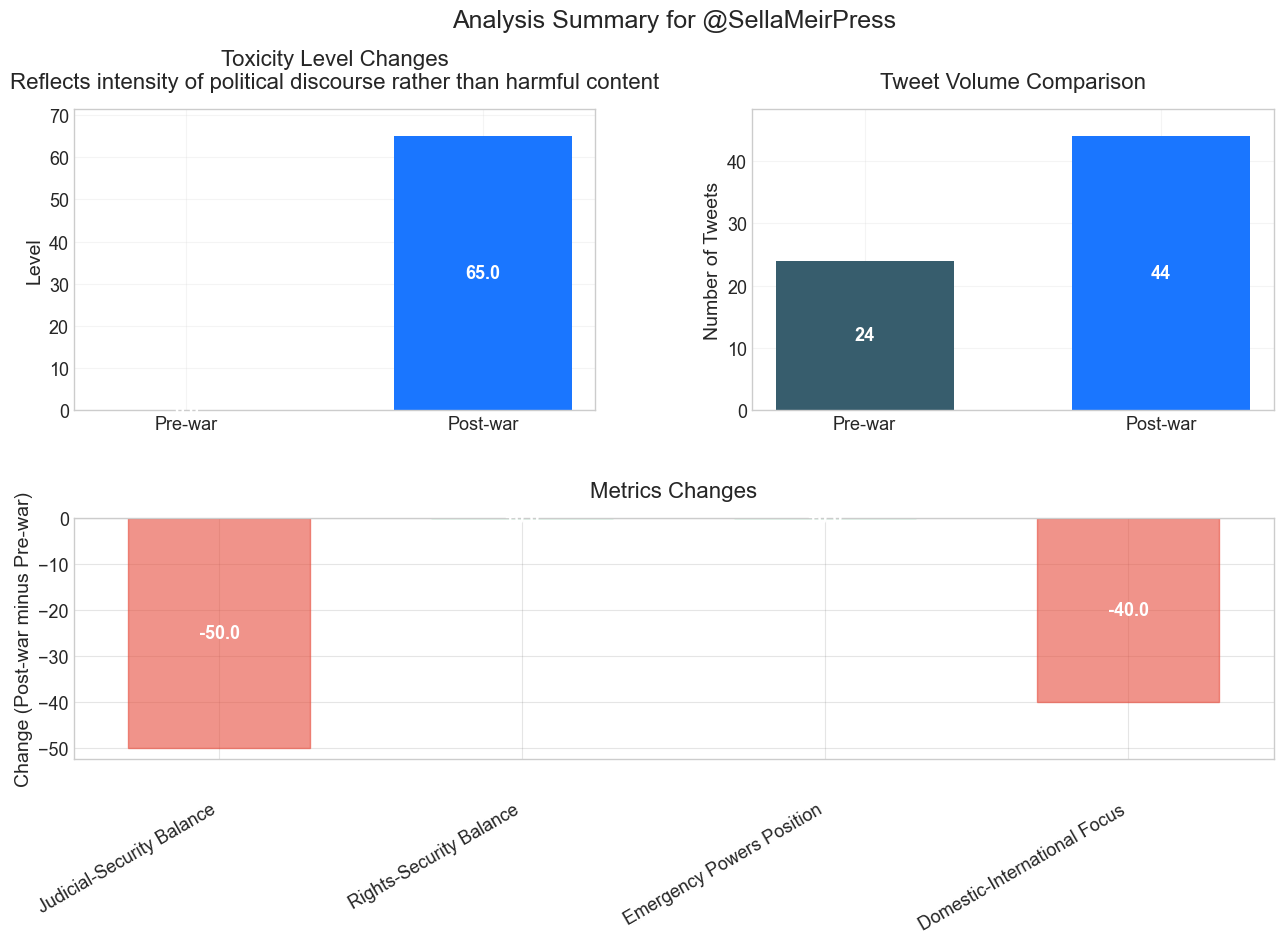

---

# User Analysis Report

## Analysis for @LawLibertyForum

### Tweet Volume

- Pre-war tweets: 17
- Post-war tweets: 9
- Change: -8 (-47.1%)

### Most Intense Tweets

_Note: Content rated as low toxicity pre-war and low toxicity post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
אפילו השאיפה לפתרון צודק איננה מקנה סמכות לעשות כן בניגוד לחוק
```

```
השאלה החשובה בנוגע לביקורת שיפוטית על החלטות של הממשלה היא - מה נותן לשופטים סמכות להחליט בנוגע לרצון העם?
```


**Post-war Period:**

```
מהו תפקידו של היועץ המשפטי לממשלה?
```

```
בעיקר כשומר סף המגן על שלטון החוק והאינטרס הציבורי?
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    85.0
Post-war:   75.0
Change:    -10.0
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    75.0
Post-war:   50.0
Change:    -25.0
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    50.0
Post-war:   50.0
Change:     +0.0
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    90.0
Post-war:   90.0
Change:     +0.0
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Challenge judicial power in Israel

- Promote constitutional reform debate

- Critique Supreme Court's role


**Post-war Top 3 Narratives:**

- Legal system reform discourse

- Judicial roles and national security

- Academic legal training promotion


**Analysis of Changes:**

_The focus shifted from challenging judicial power and critiquing the Supreme Court's role to discussing legal system reform, judicial roles in national security, and promoting academic legal training._


### New Entities Criticized

- Legal establishment

- Attorney General's Office


### No Longer Criticized

- Justice Aharon Barak

- Current judicial system

### Data Visualization


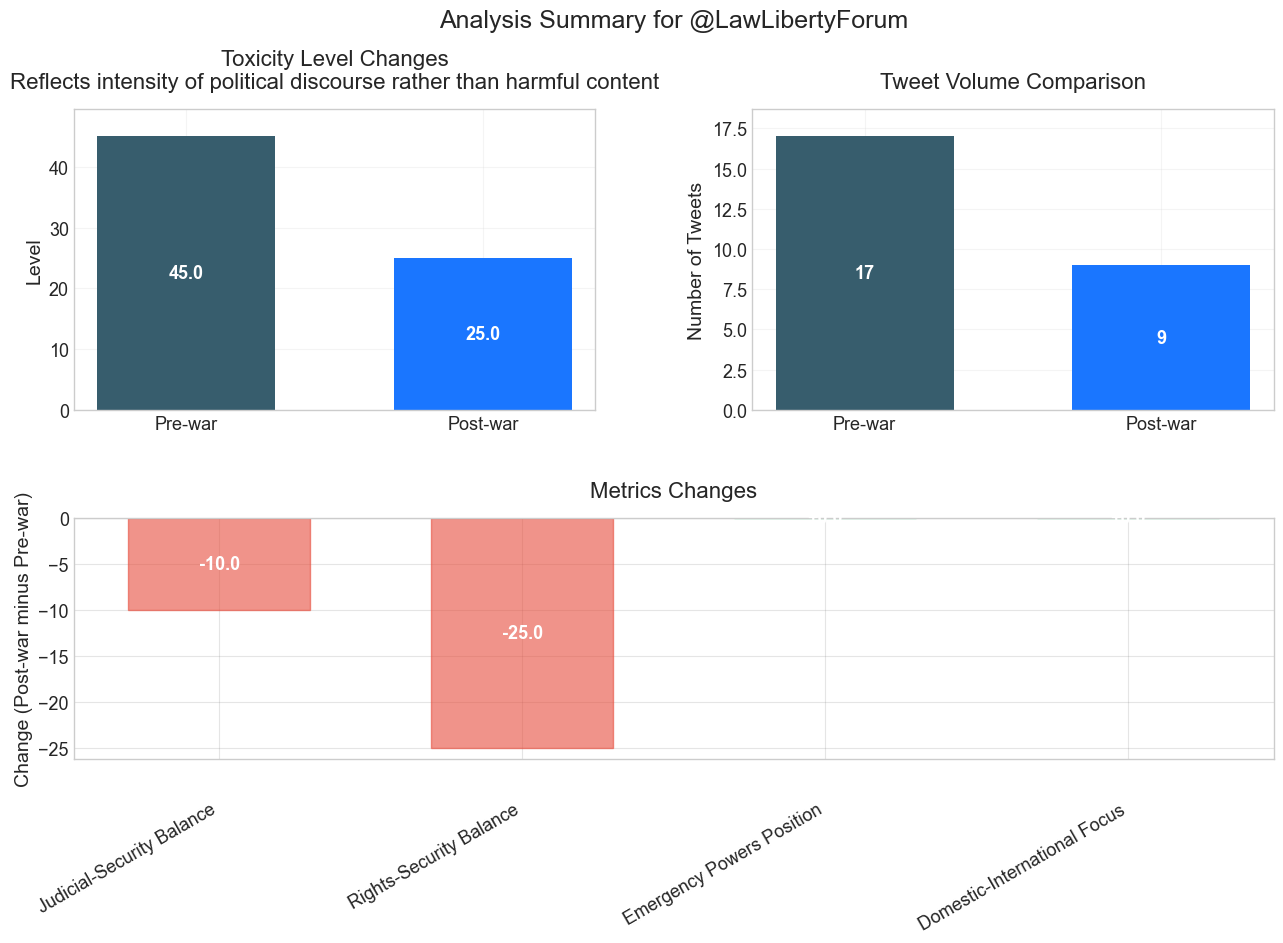

---

# User Analysis Report

## Analysis for @Meshilut

### Tweet Volume

- Pre-war tweets: 131
- Post-war tweets: 160
- Change: +29 (+22.1%)

### Most Intense Tweets

_Note: Content rated as moderately assertive pre-war and moderately assertive post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
בג' שכחו לחלוטין את מושכלות היסוד הנדרשות מהם
```

```
הכנסת לא תקבל בהכנעה את רמיסתה!
```


**Post-war Period:**

```
בג״ץ בהחלט דואג לזכויות אדם, רק לא של העם הנכון.
```

```
בשקט בשקט, מאחורי הקלעים, בטחון ישראל נקרע לגזרים.
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    85.0
Post-war:   25.0
Change:    -60.0
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    28.3
Post-war:   17.5
Change:    -10.8
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    75.0
Post-war:   80.2
Change:     +5.2
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    95.0
Post-war:   93.8
Change:     -1.2
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Judicial reform is necessary for democracy

- Supreme Court overreaches constitutional mandate

- Legal system needs fundamental restructuring


**Post-war Top 3 Narratives:**

- Supreme Court undermines national security

- Judicial system blocks government actions

- Legal system needs radical reform


**Analysis of Changes:**

_The focus shifted from concerns about judicial overreach and the need for reform to criticisms of the judiciary undermining national security and obstructing government actions._


### New Entities Criticized

- Supreme Court (High Court of Justice)

- Gali Baharav-Miara

- Yitzhak Amit


### No Longer Criticized

- Supreme Court (Bagatz)

- Dina Zilber

- Esther Hayut

### Data Visualization


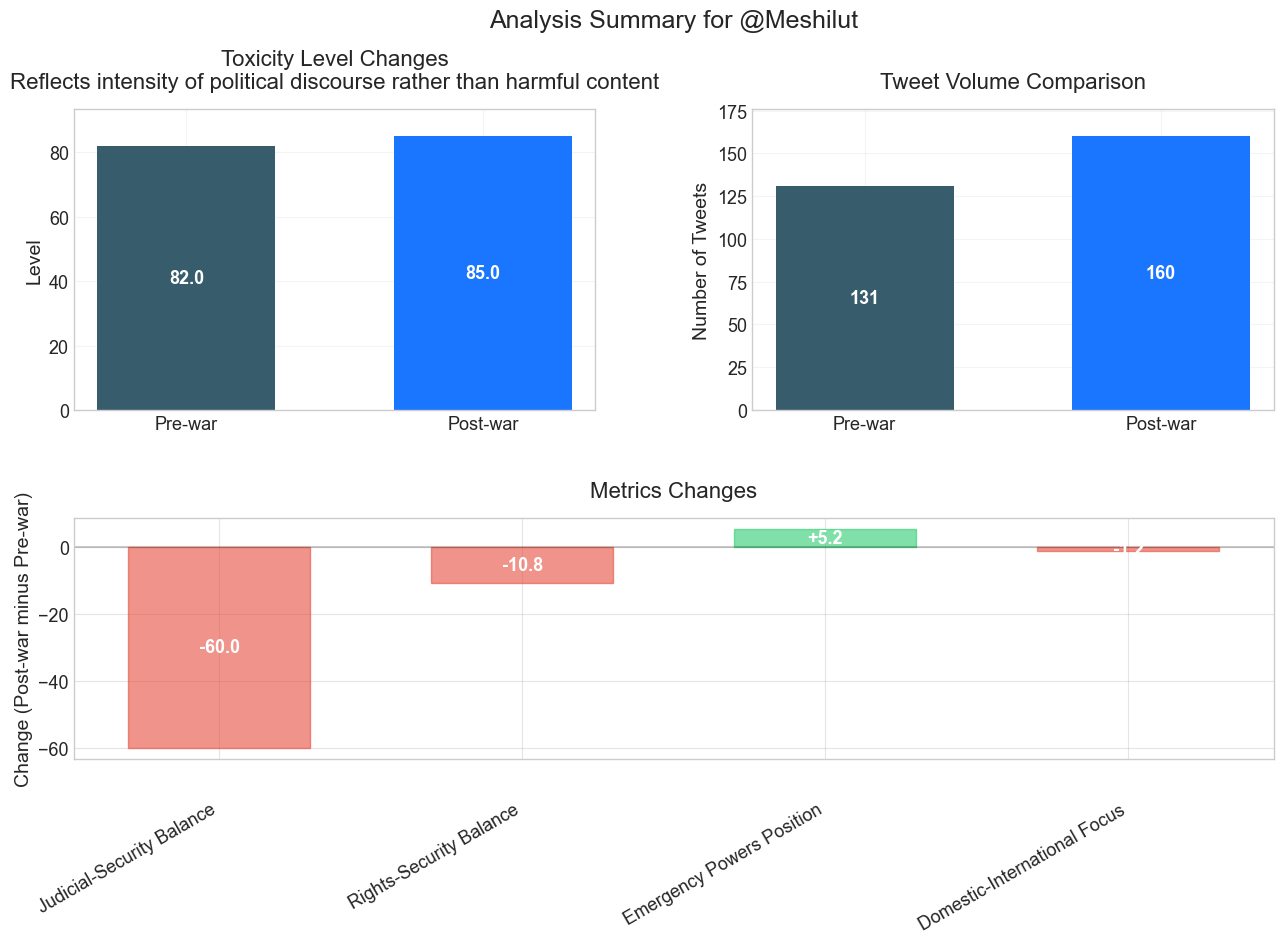

---

# User Analysis Report

## Analysis for @MalkaElad

### Tweet Volume

- Pre-war tweets: 34
- Post-war tweets: 886
- Change: +852 (+2505.9%)

### Most Intense Tweets

_Note: Content rated as low toxicity pre-war and moderately assertive post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
כתבה כל כך אורווליאנית. מעבירים חוק שכל תכליתו היא פחות מעורבות ממשלתית ופוליטית בתקשורת והיא אומרת הפוך.
```

```
וזה כמובן חוץ מהעובדה הפשוטה שהרגולטור הנוכחי קובי מי יקבל רישיון חדשות והאם הוא מדווח כמו שצריך
```


**Post-war Period:**

```
לכלא, אחד אחרי השני. בלי למצמץ, בלי לגמגם ובהליך פלילי על כל המשתמע ממנו.
```

```
לא משנה מה דעתכם על נתניהו, התגובה למדינה שניסתה לאיים על חיי ראש ממשלת ישראל צריכה להיות אחת: חיסול מנהיג המדינה.
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    75.0
Post-war:   53.1
Change:    -21.9
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    75.0
Post-war:   42.9
Change:    -32.1
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    50.0
Post-war:   70.5
Change:    +20.5
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    85.0
Post-war:   80.7
Change:     -4.3
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Reduce political influence in media regulation

- Open news market to competition

- Challenge existing media power structures


**Post-war Top 3 Narratives:**

- Judicial reform and political transformation

- Military service draft controversy

- Israel's national security strategy


**Analysis of Changes:**

_The focus shifted from media regulation and competition to judicial reform, military service, and national security, reflecting a transition from domestic to geopolitical priorities._


### New Entities Criticized

- Netanyahu

- Benny Gantz

- Yair Lapid


### No Longer Criticized

- Ministry of Communication

- N12 News Channel

- Current Media Regulator

### Data Visualization


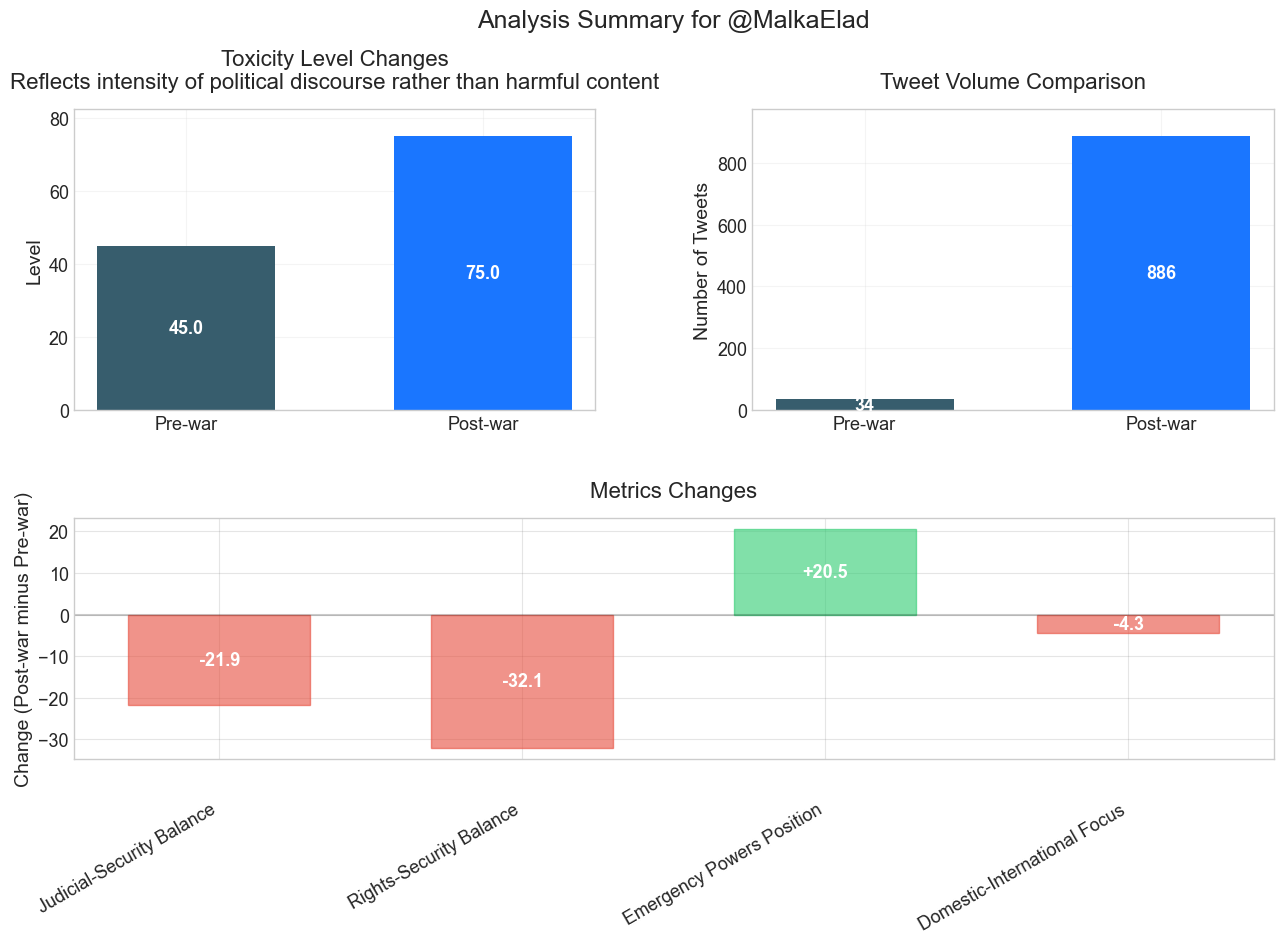

---

# User Analysis Report

## Analysis for @matanp2

### Tweet Volume

- Pre-war tweets: 31
- Post-war tweets: 130
- Change: +99 (+319.4%)

### Most Intense Tweets

_Note: Content rated as moderately assertive pre-war and moderately assertive post-war, 
primarily reflecting intensity of political discourse._


**Pre-war Period:**

```
מדינת ישראל לא תהיה יהודית ולא תהיה דמוקרטית אם בג"ץ
```

```
בג"ץ הגיע הבוקר לאחוזתה המפוארת של כבוד הנשיאה אסתר חיות
```


**Post-war Period:**

```
לכי על זה. תהיי הראשונה. תובילי. נראה אותך מחזירה את המשכורת שלך.
```

```
נא ממך האר את עינינו
```

### Change Metrics


**Judicial-Security Balance**
_(0: security focus, 100: judicial reform focus)_

```
Pre-war:    75.0
Post-war:   68.4
Change:     -6.6
```


**Rights-Security Balance**
_(0: security focus, 100: rights focus)_

```
Pre-war:    25.0
Post-war:   31.7
Change:     +6.7
```


**Emergency Powers Position**
_(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)_

```
Pre-war:    75.0
Post-war:   75.0
Change:     +0.0
```


**Domestic-International Focus**
_(0: international focus, 100: domestic focus)_

```
Pre-war:    90.0
Post-war:   86.7
Change:     -3.3
```

### Narrative Evolution


**Pre-war Top 3 Narratives:**

- Judicial reform essential for democratic renewal

- National camp must resist post-Zionist elites

- Israel's identity threatened by Supreme Court


**Post-war Top 3 Narratives:**

- Defend Jewish national identity

- Challenge existing political elites

- Promote right-wing political transformation


**Analysis of Changes:**

_The pre-war narratives focused on judicial reform and resisting perceived threats to Israel's identity. The post-war narratives shifted to defending Jewish nationalism and promoting a right-wing political transformation._


### New Entities Criticized

- Supreme Court (Bagatz)

- Biden Administration

- Benny Gantz


### No Longer Criticized

- Supreme Court

- Supreme Court Justices

- Esther Hayut

### Data Visualization


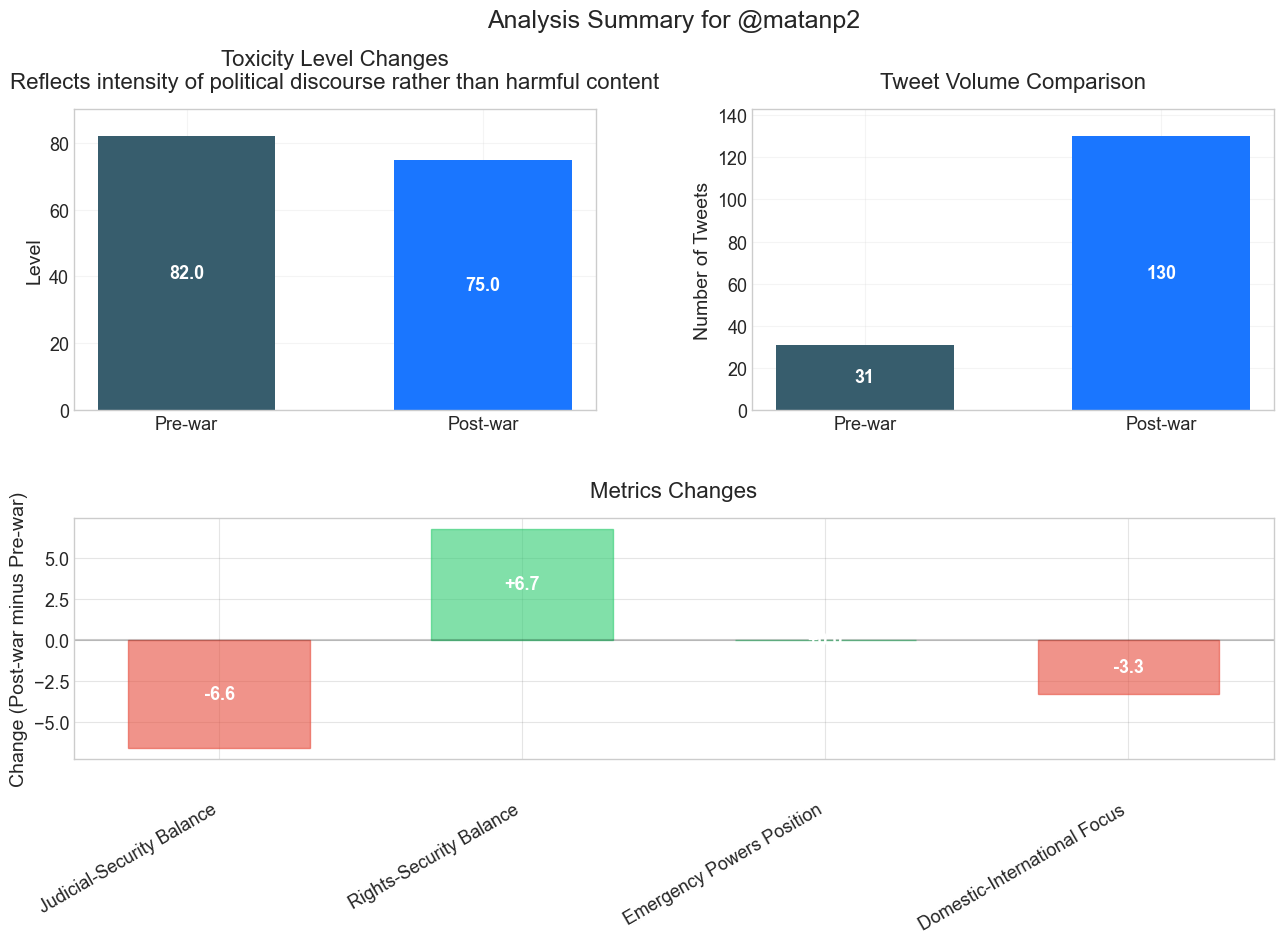


Report generation completed successfully!


In [1]:
# Cell 5: Generate Individual Users Report
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, clear_output
from report_generator import UsersReport

# Find the most recent enhanced analysis files
pre_war_pattern = os.path.join('data', 'analysis', 'pre_war', 'merged_analysis_pre_war_enhanced_*.csv')
post_war_pattern = os.path.join('data', 'analysis', 'post_war', 'merged_analysis_post_war_enhanced_*.csv')

pre_war_files = glob.glob(pre_war_pattern)
post_war_files = glob.glob(post_war_pattern)

if not pre_war_files or not post_war_files:
    raise FileNotFoundError("Enhanced analysis files not found. Please run the enhanced analysis first.")

# Get the most recent files
pre_war_file = max(pre_war_files, key=os.path.getctime)
post_war_file = max(post_war_files, key=os.path.getctime)

# Read the enhanced analysis results
pre_war_enhanced = pd.read_csv(pre_war_file)
post_war_enhanced = pd.read_csv(post_war_file)

# Define users to analyze
test_users = TARGET_USERS = [
    "Meir_Rubin", "MisgavINS", "ptr_dvd", "AmiadCohen", "EVKontorovich",
    "SagiBarmak", "KoheletForum", "rotem_sella", "ShimonNataf", "russell_sl",
    "MalkaElad", "SaraHaetzniCohe", "berale_crombie", "Argaman_Inst",
    "ShovalRonen", "Shauli_Sharf", "DBortnovskiy", "hashiloach",
    "SellaMeirPress", "LawLibertyForum", "Meshilut", "MalkaElad", "matanp2"
]

# Initialize report generator
report_generator = UsersReport()

# Generate reports for each user
for username in test_users:
    # Get user data
    pre_war_user = pre_war_enhanced[pre_war_enhanced['username'] == username]
    post_war_user = post_war_enhanced[post_war_enhanced['username'] == username]
    
    if pre_war_user.empty or post_war_user.empty:
        print(f"No data found for user {username}")
        continue
    
    # Generate report and figures
    report, figures = report_generator.generate_report(
        pre_war_data=pre_war_user,
        post_war_data=post_war_user,
        username=username
    )
    
    # Display report content
    display(Markdown(report))
    
    # Display figures
    for fig in figures:
        display(fig)
        plt.close(fig)
    
    # Add separator between users (except for last user)
    if username != test_users[-1]:
        display(Markdown("---"))

print("\nReport generation completed successfully!")

Generate users report external - HTML

In [5]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from report_generator import UsersReport
from html_exporter import HTMLExporter

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['axes.titlesize'] = 16

# Find most recent enhanced analysis files
pre_war_pattern = 'data/analysis/pre_war/merged_analysis_pre_war_enhanced_*.csv'
post_war_pattern = 'data/analysis/post_war/merged_analysis_post_war_enhanced_*.csv'

pre_war_files = glob.glob(pre_war_pattern)
post_war_files = glob.glob(post_war_pattern)

if not pre_war_files or not post_war_files:
    raise FileNotFoundError("Could not find required analysis files")

# Get most recent files
pre_war_file = max(pre_war_files)
post_war_file = max(post_war_files)

print(f"Using pre-war file: {pre_war_file}")
print(f"Using post-war file: {post_war_file}")

# Read the data
pre_war_enhanced = pd.read_csv(pre_war_file)
post_war_enhanced = pd.read_csv(post_war_file)

# Users to analyze
users = [
    "Meir_Rubin", "MisgavINS", "ptr_dvd", "AmiadCohen", "EVKontorovich",
    "SagiBarmak", "KoheletForum", "rotem_sella", "ShimonNataf", "russell_sl",
    "MalkaElad", "SaraHaetzniCohe", "berale_crombie", "Argaman_Inst",
    "ShovalRonen", "Shauli_Sharf", "DBortnovskiy", "hashiloach",
    "SellaMeirPress", "LawLibertyForum", "Meshilut", "MalkaElad", "matanp2"
]
# Initialize report generator and HTML exporter
report_generator = UsersReport()
html_exporter = HTMLExporter()

successful_users = []

# Generate reports for each user
for username in users:
    print(f"\nGenerating report for @{username}...")
    
    # Check if user exists in both periods
    pre_war_data = pre_war_enhanced[pre_war_enhanced['username'] == username]
    post_war_data = post_war_enhanced[post_war_enhanced['username'] == username]
    
    if pre_war_data.empty or post_war_data.empty:
        print(f"Skipping @{username} - no data found in one or both periods")
        continue
        
    try:
        # Pass both pre_war and post_war data to generate_report
        report_text, figures = report_generator.generate_report(
            pre_war_data=pre_war_data,
            post_war_data=post_war_data,
            username=username
        )
        html_exporter.export_report(report_text, figures)
        successful_users.append(username)
        print(f"Successfully generated report for @{username}")
    except Exception as e:
        print(f"Error generating report for @{username}: {str(e)}")

print(f"\nSuccessfully generated reports for {len(successful_users)} users")

# Generate index page if any reports were successful
if successful_users:
    html_exporter.generate_user_index(successful_users)
    print("Generated user index page at docs/users/index.html")
else:
    print("No reports were generated successfully")

Using pre-war file: data/analysis/pre_war\merged_analysis_pre_war_enhanced_20250114_105124.csv
Using post-war file: data/analysis/post_war\merged_analysis_post_war_enhanced_20250114_114930.csv

Generating report for @ptr_dvd...
Successfully generated report for @ptr_dvd

Generating report for @SagiBarmak...
Successfully generated report for @SagiBarmak

Generating report for @KoheletForum...
Successfully generated report for @KoheletForum

Generating report for @rotem_sella...
Successfully generated report for @rotem_sella

Generating report for @MalkaElad...
Successfully generated report for @MalkaElad

Generating report for @matanp2...
Successfully generated report for @matanp2

Successfully generated reports for 6 users
Generated user index page at docs/users/index.html


Group analysis and reporting


Attempting LLM narrative analysis...

Attempting evolution analysis with LLM...

Evolution prompt: You are a political discourse analyst. Analyze how these narratives changed from pre-war to post-war:

Pre-war Top Narratives:
['- Promoting Free-Market Economics and Reduced Government Regulation (22.2%)', "- Promoting Israel's Jewish National Identity (19.4%)", '- Judicial Reform and Oversight Critique (25.0%)', '- Opposition to Labor Unions and Left-Wing Institutions (8.3%)']

Post-war Top Narratives:
['- Promoting Free-Market Economics and Reduced Government Regulation (22.2%)', "- Promoting Israel's Jewish National Identity (19.4%)", '- Judicial Reform and Oversight Critique (11.1%)', '- Defending National Security and Government Actions (22.2%)', '- Opposition to Labor Unions and Left-Wing Institutions (16.7%)']

Return ONLY a concise 40-word analysis focusing on the key shifts in narrative focus, new themes that emerged, and themes that disappeared. Focus on the most significant c

# Group Analysis Report

**Analysis Periods:**
- Pre-war: July 9, 2023 - October 7, 2023 (90 days before the war)
- Post-war: October 1, 2024 - December 30, 2024 (90 days at end of 2024)

## Overall Statistics

### Tweet Volume Analysis

- Total Pre-war Tweets: 1,568
- Total Post-war Tweets: 5,935 (+278.5%)

Top Volume Changes:
- <span style='color: #3498DB'>@ShimonNataf</span>: +1,985 tweets (+1492.5%)
- <span style='color: #3498DB'>@MalkaElad</span>: +852 tweets (+2505.9%)
- <span style='color: #3498DB'>@berale_crombie</span>: +483 tweets (+670.8%)
- <span style='color: #3498DB'>@SaraHaetzniCohe</span>: +477 tweets (+795.0%)
- <span style='color: #3498DB'>@SagiBarmak</span>: +446 tweets (+368.6%)


### Most Toxic Tweets

Pre-war Period:
- <span style='color: #3498DB'>@Meshilut</span> (toxicity: 80.0):
  ```
  הכנסת לא תקבל בהכנעה את רמיסתה!
  ```
- <span style='color: #3498DB'>@Meshilut</span> (toxicity: 80.0):
  ```
  מערכת אכיפת החוק בראשות גלי בהרב מיארה ועמית איסמן, היא המחולל במחדל של האנרכיה ברחובות. זאת ההשמדה של הדמוקרטיה. לא שום דבר אחר.
  ```
- <span style='color: #3498DB'>@SaraHaetzniCohe</span> (toxicity: 80.0):
  ```
  מה לכל הרוחות חשבתם שיקרה כשאלוף (!) במיל'נמרוד שפר הודיע קבל עם ורדיו שהוא לא היה מגיע להפציץ את האויב בסוריה?
  ```

Post-war Period:
- <span style='color: #3498DB'>@MalkaElad</span> (toxicity: 80.0):
  ```
  אם מדינת ישראל רוצה להיחשב הומנית היא פשוט צריכה להרוג עוד חיילי צה״ל - זו משמעות הטענה ההזויה הזו.
  ```
- <span style='color: #3498DB'>@MalkaElad</span> (toxicity: 80.0):
  ```
  ישראל צריכה להכריז עוד היום: כל עזתי שיראה ויזת שהיה במדינה מערבית או מוסלמית מתונה - יקבל הסעה לנתב״ג וכרטיס טיסה על חשבוננו.
  ```
- <span style='color: #3498DB'>@Meshilut</span> (toxicity: 80.0):
  ```
  כדי לא לפגוע בסיכויי הנורמטיביות של המחבל להשתלב בחברה שאותה הוא רוצה להשמיד - שופטי העליון מעניקים מתנה למחבל ועל הדרך מעודדים את הפיגוע הבא.
  ```


### Metrics Analysis


**Judicial-Security Balance**
(0: security focus, 100: judicial reform focus)

**Group Average Change: -30.7**

**Top Changes:**
- <span style='color: #3498DB'>@Meshilut</span> <span style='color: #E74C3C'>-50.0 points</span> │ Pre: 75.0 → Post: 25.0
- <span style='color: #3498DB'>@matanp2</span> <span style='color: #E74C3C'>-50.0 points</span> │ Pre: 75.0 → Post: 25.0
- <span style='color: #3498DB'>@SaraHaetzniCohe</span> <span style='color: #E74C3C'>-43.2 points</span> │ Pre: 75.0 → Post: 31.8
- <span style='color: #3498DB'>@russell_sl</span> <span style='color: #E74C3C'>-41.7 points</span> │ Pre: 66.7 → Post: 25.0
- <span style='color: #3498DB'>@AmiadCohen</span> <span style='color: #E74C3C'>-38.8 points</span> │ Pre: 68.8 → Post: 30.0



**Rights-Security Balance**
(0: security focus, 100: rights focus)

**Group Average Change: -25.1**

**Top Changes:**
- <span style='color: #3498DB'>@Meshilut</span> <span style='color: #E74C3C'>-50.0 points</span> │ Pre: 75.0 → Post: 25.0
- <span style='color: #3498DB'>@SaraHaetzniCohe</span> <span style='color: #E74C3C'>-43.2 points</span> │ Pre: 75.0 → Post: 31.8
- <span style='color: #3498DB'>@russell_sl</span> <span style='color: #E74C3C'>-34.3 points</span> │ Pre: 59.3 → Post: 25.0
- <span style='color: #3498DB'>@rotem_sella</span> <span style='color: #E74C3C'>-32.6 points</span> │ Pre: 70.1 → Post: 37.5
- <span style='color: #3498DB'>@KoheletForum</span> <span style='color: #E74C3C'>-32.5 points</span> │ Pre: 70.0 → Post: 37.5



**Emergency Powers Position**
(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)

**Group Average Change: +24.3**

**Top Changes:**
- <span style='color: #3498DB'>@Meshilut</span> <span style='color: #2ECC71'>+50.0 points</span> │ Pre: 25.0 → Post: 75.0
- <span style='color: #3498DB'>@russell_sl</span> <span style='color: #2ECC71'>+44.0 points</span> │ Pre: 31.0 → Post: 75.0
- <span style='color: #3498DB'>@matanp2</span> <span style='color: #2ECC71'>+41.7 points</span> │ Pre: 25.0 → Post: 66.7
- <span style='color: #3498DB'>@KoheletForum</span> <span style='color: #2ECC71'>+30.8 points</span> │ Pre: 32.5 → Post: 63.3
- <span style='color: #3498DB'>@berale_crombie</span> <span style='color: #2ECC71'>+23.0 points</span> │ Pre: 25.0 → Post: 48.0



**Domestic-International Focus**
(0: international focus, 100: domestic focus)

**Group Average Change: -14.1**

**Top Changes:**
- <span style='color: #3498DB'>@russell_sl</span> <span style='color: #E74C3C'>-46.9 points</span> │ Pre: 84.4 → Post: 37.5
- <span style='color: #3498DB'>@KoheletForum</span> <span style='color: #E74C3C'>-32.7 points</span> │ Pre: 82.7 → Post: 50.0
- <span style='color: #3498DB'>@rotem_sella</span> <span style='color: #E74C3C'>-23.9 points</span> │ Pre: 85.6 → Post: 61.7
- <span style='color: #3498DB'>@AmiadCohen</span> <span style='color: #E74C3C'>-21.5 points</span> │ Pre: 88.9 → Post: 67.4
- <span style='color: #3498DB'>@Meshilut</span> <span style='color: #E74C3C'>-17.0 points</span> │ Pre: 92.0 → Post: 75.0



### Entity Changes

**Top New Attacked Entities (Post-war):**
• <span style='color: #3498DB'>Leftist politicians</span>
• <span style='color: #3498DB'>Supreme Court (בג״ץ)</span>
• <span style='color: #3498DB'>Leftist ideology</span>
• <span style='color: #3498DB'>Ronen Shoval</span>
• <span style='color: #3498DB'>Teachers' unions</span>
• <span style='color: #3498DB'>Justin Trudeau</span>
• <span style='color: #3498DB'>Nir Barkat</span>
• <span style='color: #3498DB'>UNRWA</span>

**No Longer Attacked (Pre-war only):**
• <span style='color: #9B59B6'>Amos Yadlin</span>
• <span style='color: #9B59B6'>Avi Maoz</span>
• <span style='color: #9B59B6'>Biden</span>
• <span style='color: #9B59B6'>Ruth Gavison</span>
• <span style='color: #9B59B6'>Labor unions</span>
• <span style='color: #9B59B6'>Regulators</span>
• <span style='color: #9B59B6'>Daphne Barak</span>
• <span style='color: #9B59B6'>Aharon Barak</span>


### Narrative Evolution Analysis

#### Consistent Narratives
- **Promoting Free-Market Economics and Reduced Government Regulation**
  - Pre-war: 22.2%
  - Post-war: 22.2%
- **Promoting Israel's Jewish National Identity**
  - Pre-war: 19.4%
  - Post-war: 19.4%

#### Changed Narratives
- **Judicial Reform and Oversight Critique** (Transformed)
  - Pre-war: 25.0%
  - Post-war: 11.1%
- **Defending National Security and Government Actions** (Emerged)
  - Pre-war: 0.0%
  - Post-war: 22.2%
- **Opposition to Labor Unions and Left-Wing Institutions** (Transformed)
  - Pre-war: 8.3%
  - Post-war: 16.7%

**Evolution Analysis:** Post-war discourse shifted from judicial reform to national security, with defense narratives rising. Labor union opposition increased, while judicial critique declined, reflecting a wartime prioritization of security and national identity over internal political debates.


### Emotional Tones

Pre-war Top Emotional Tones:
- cynical: 50.0%
- angry: 33.3%
- frustrated: 16.7%

Post-war Top Emotional Tones:
- angry: 50.0%
- cynical: 50.0%



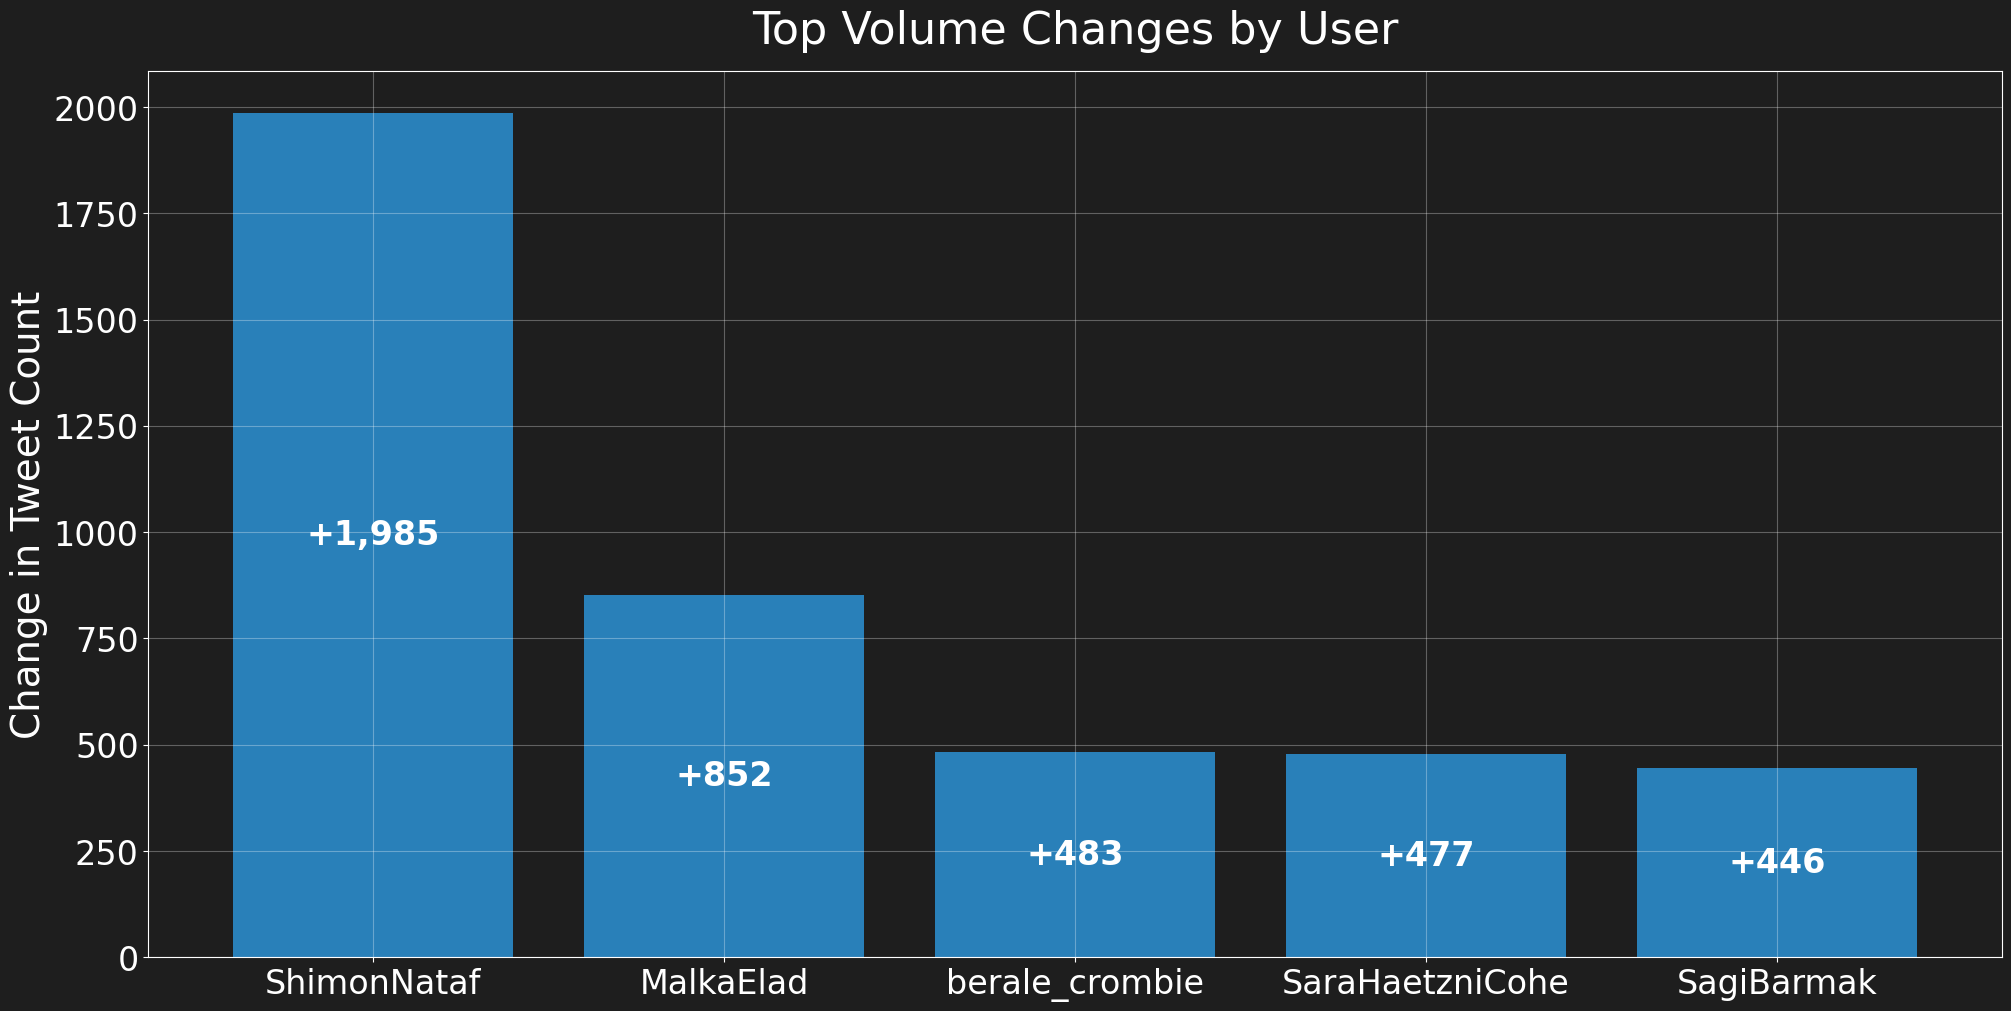

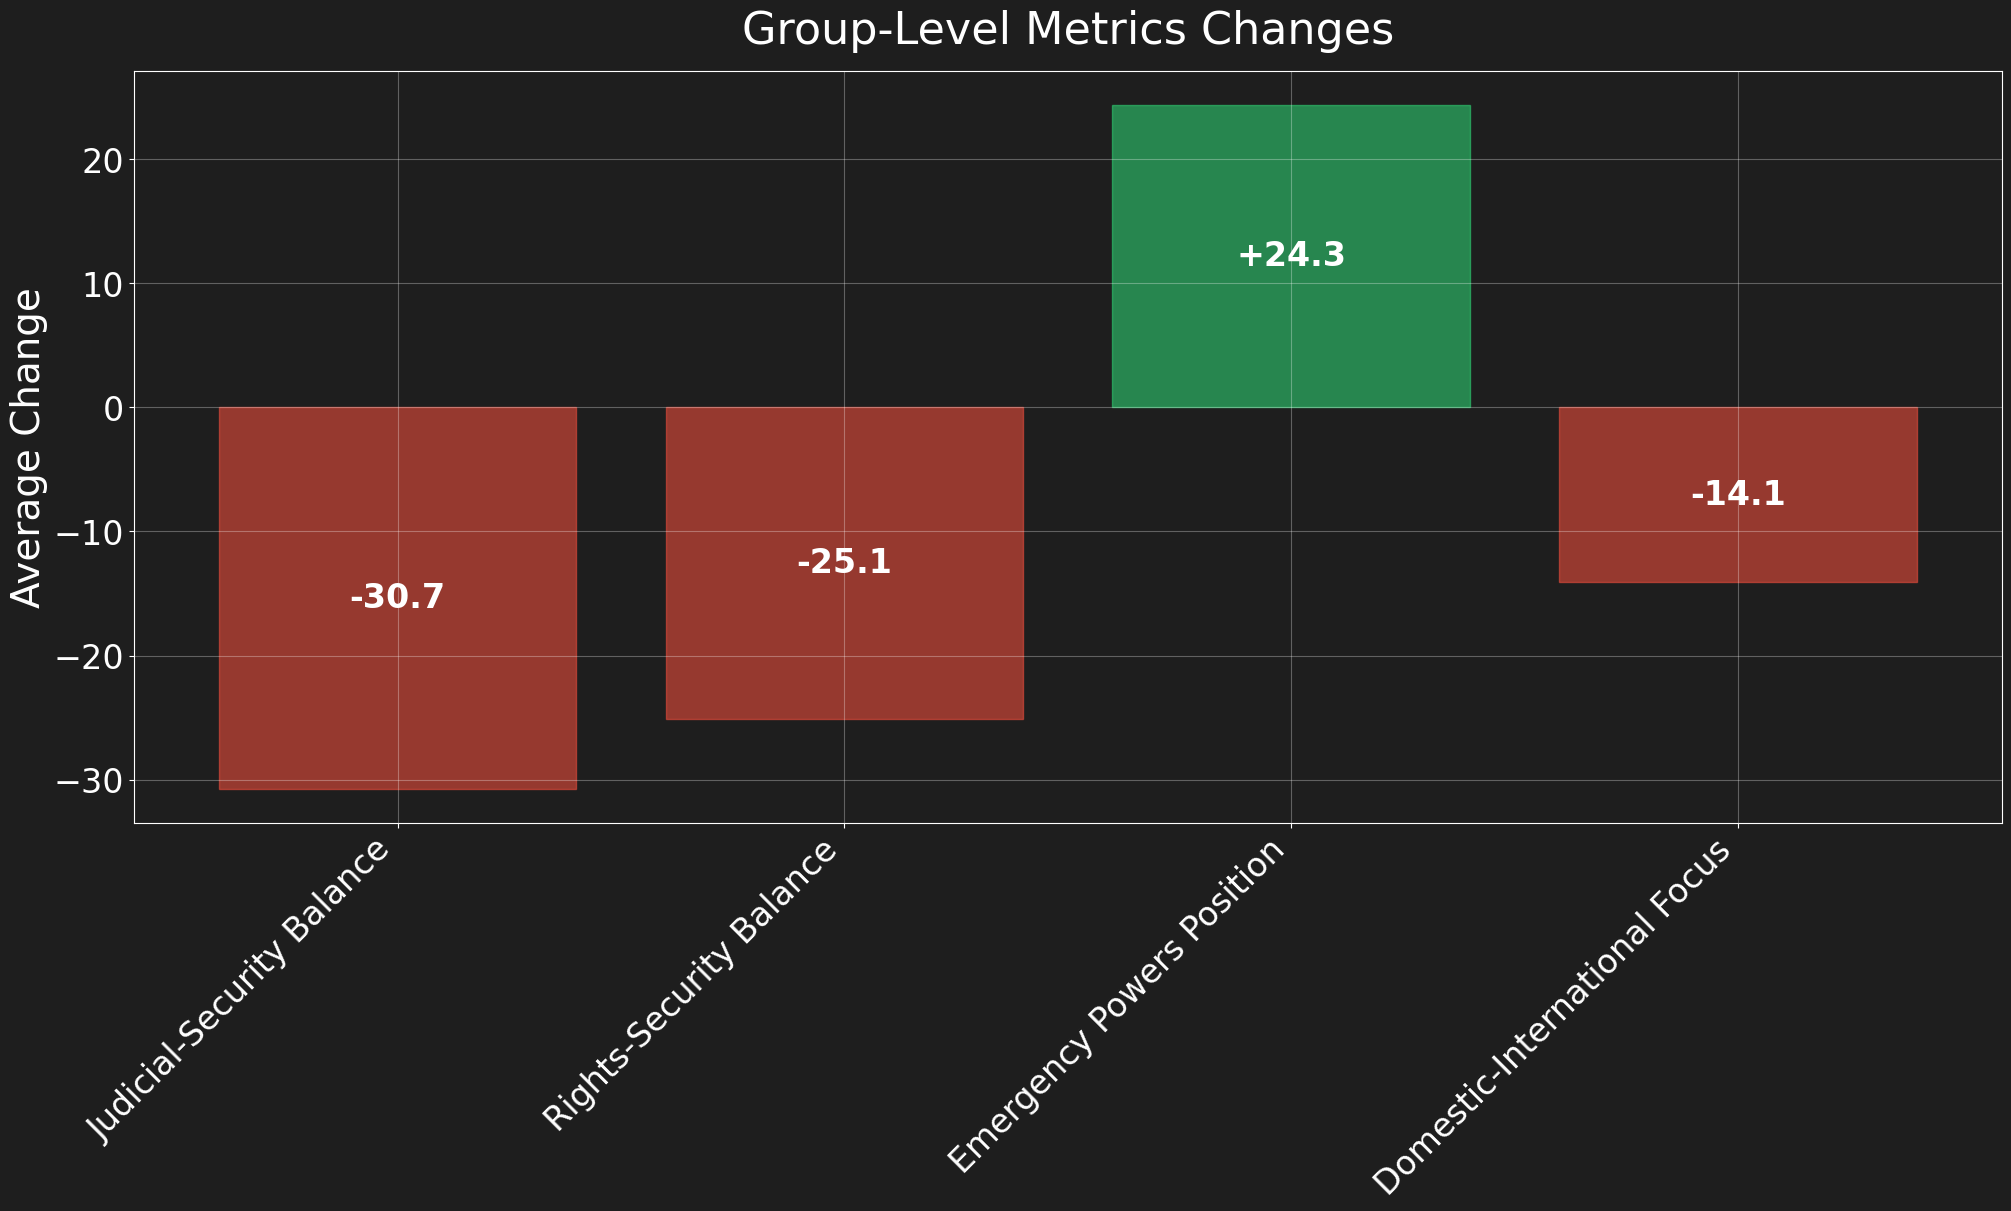

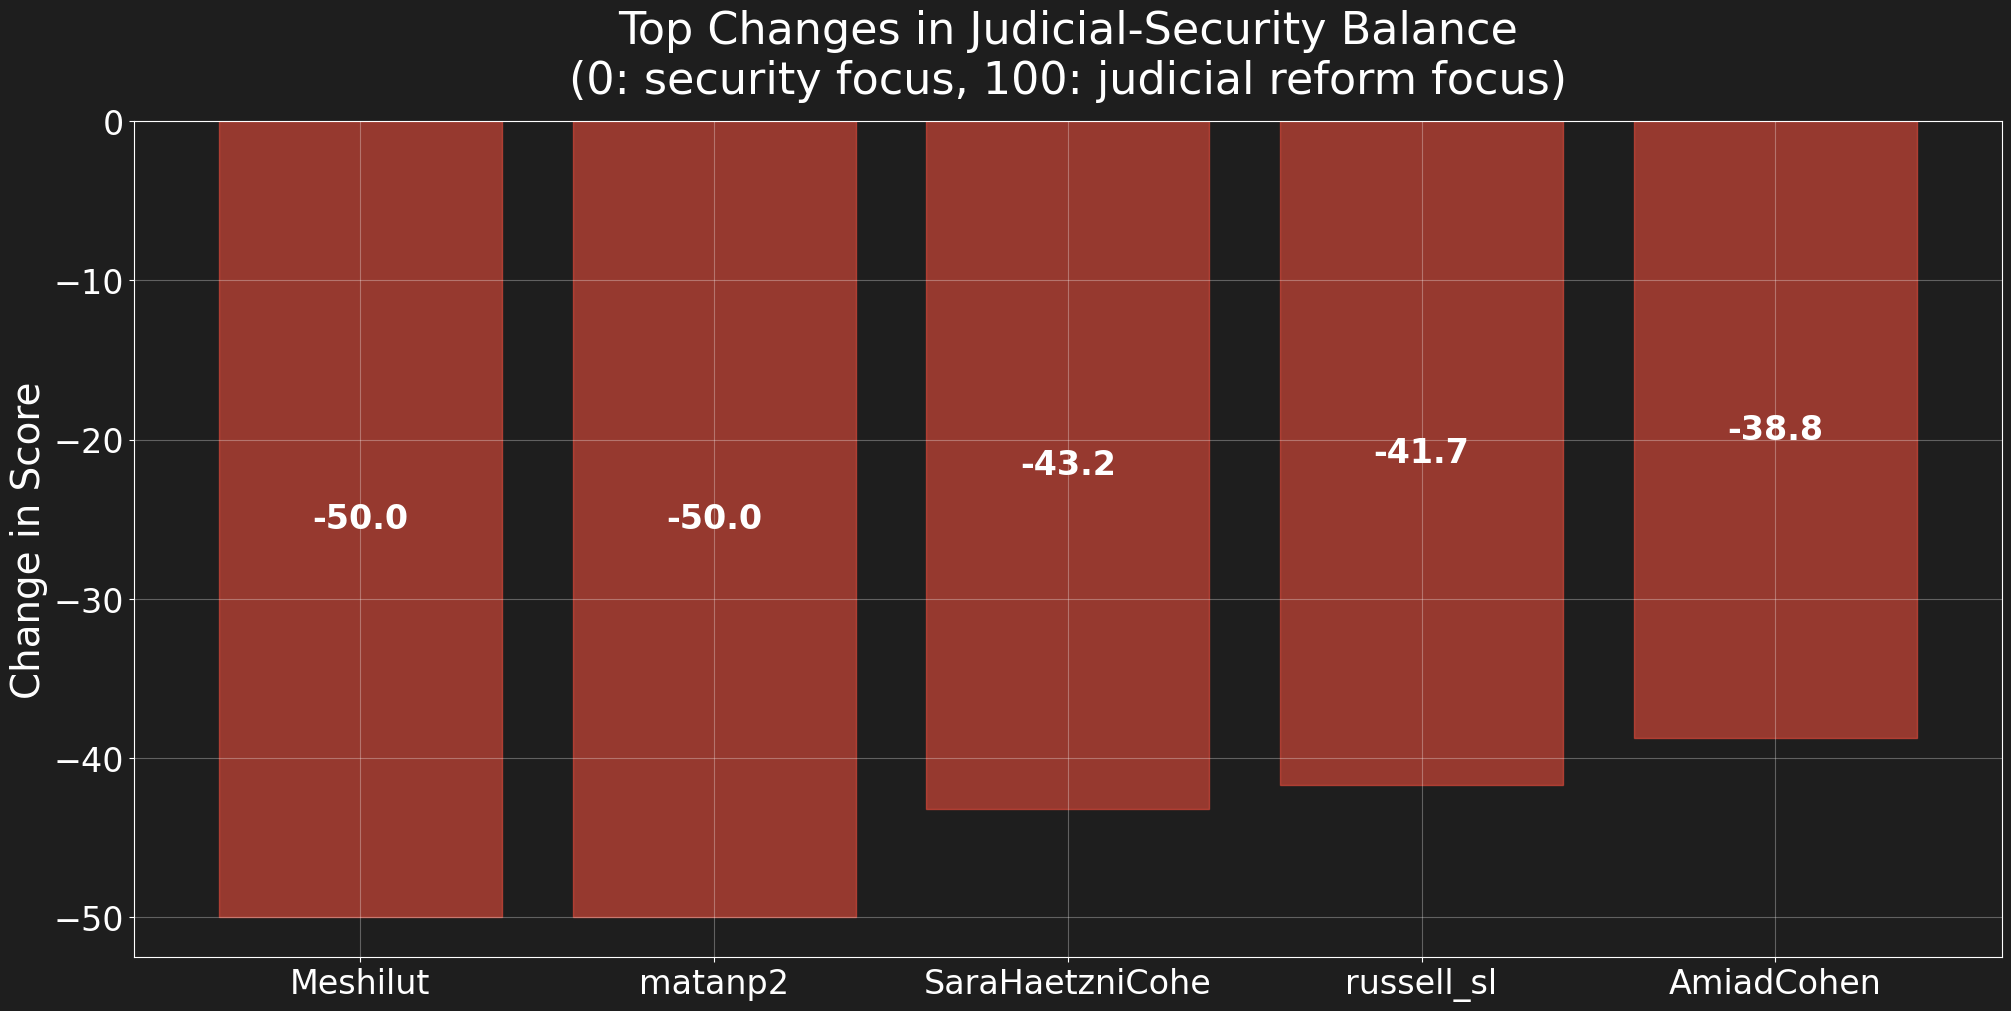

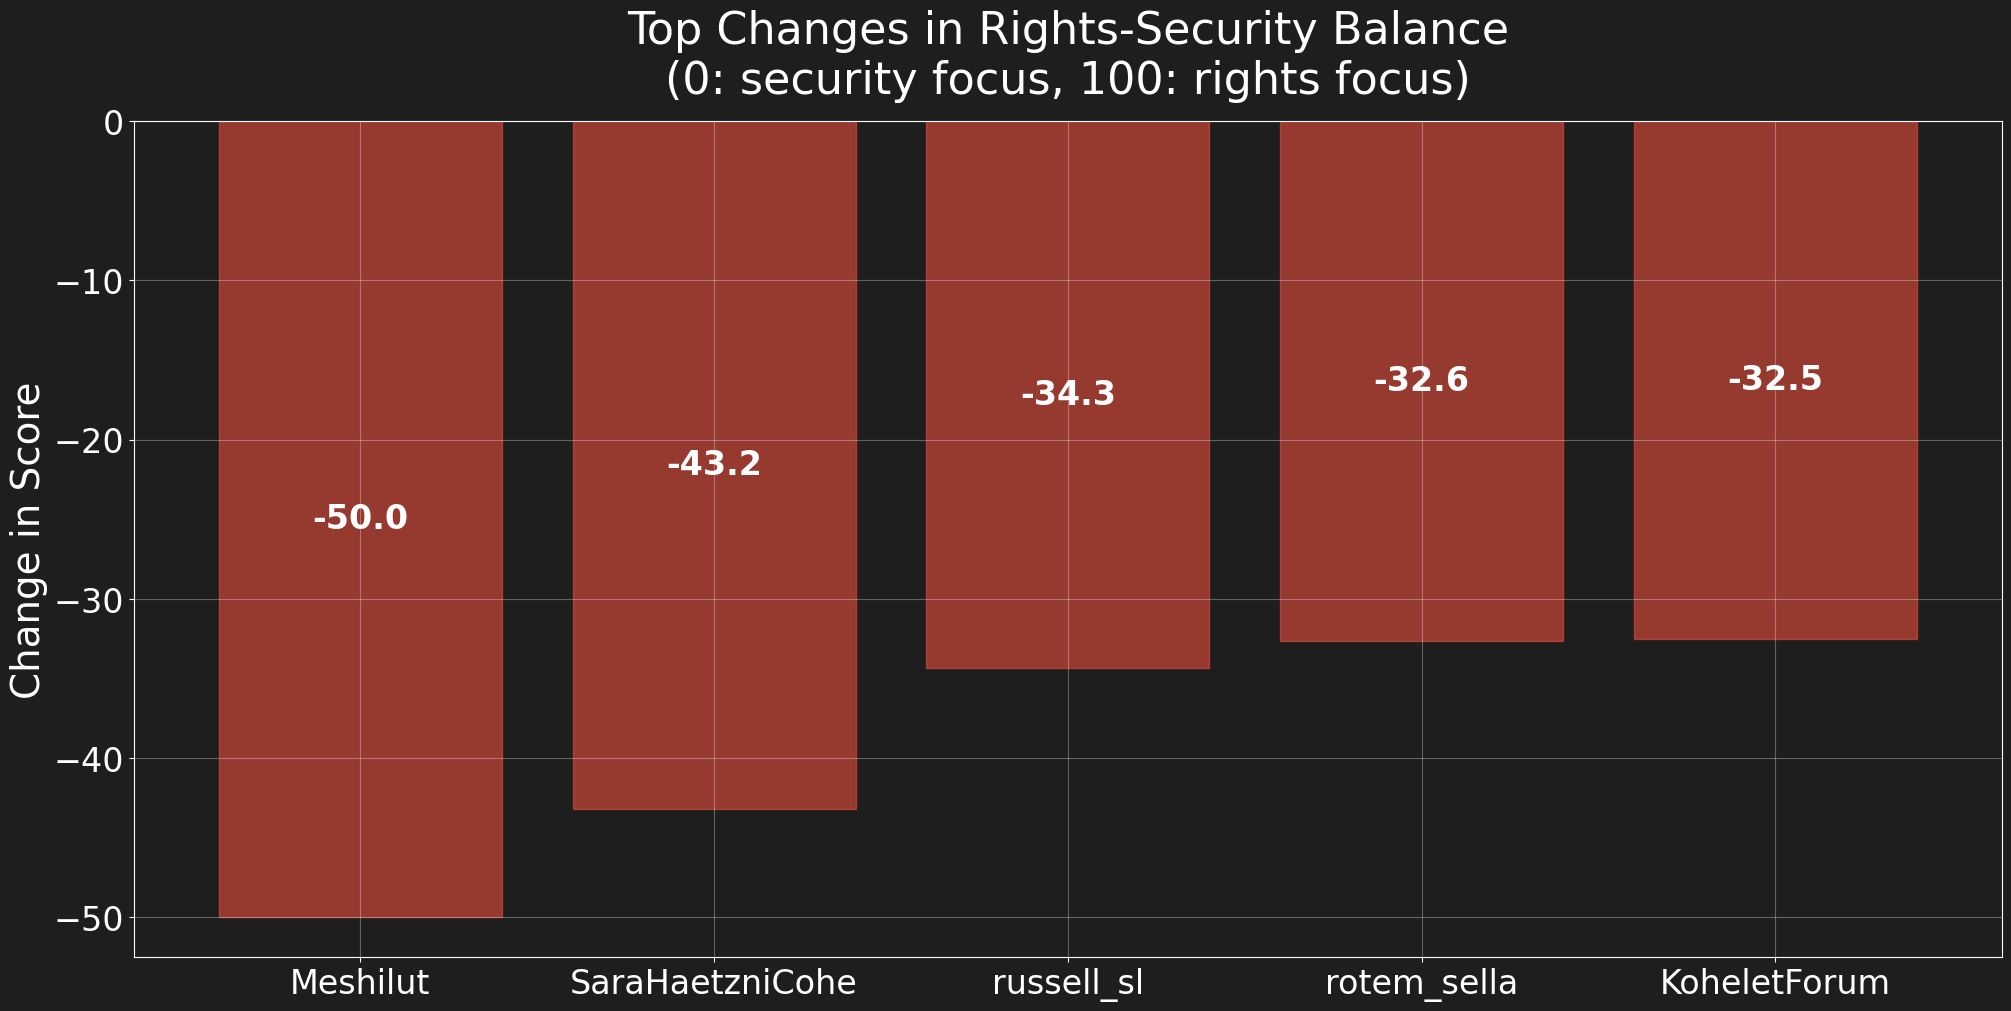

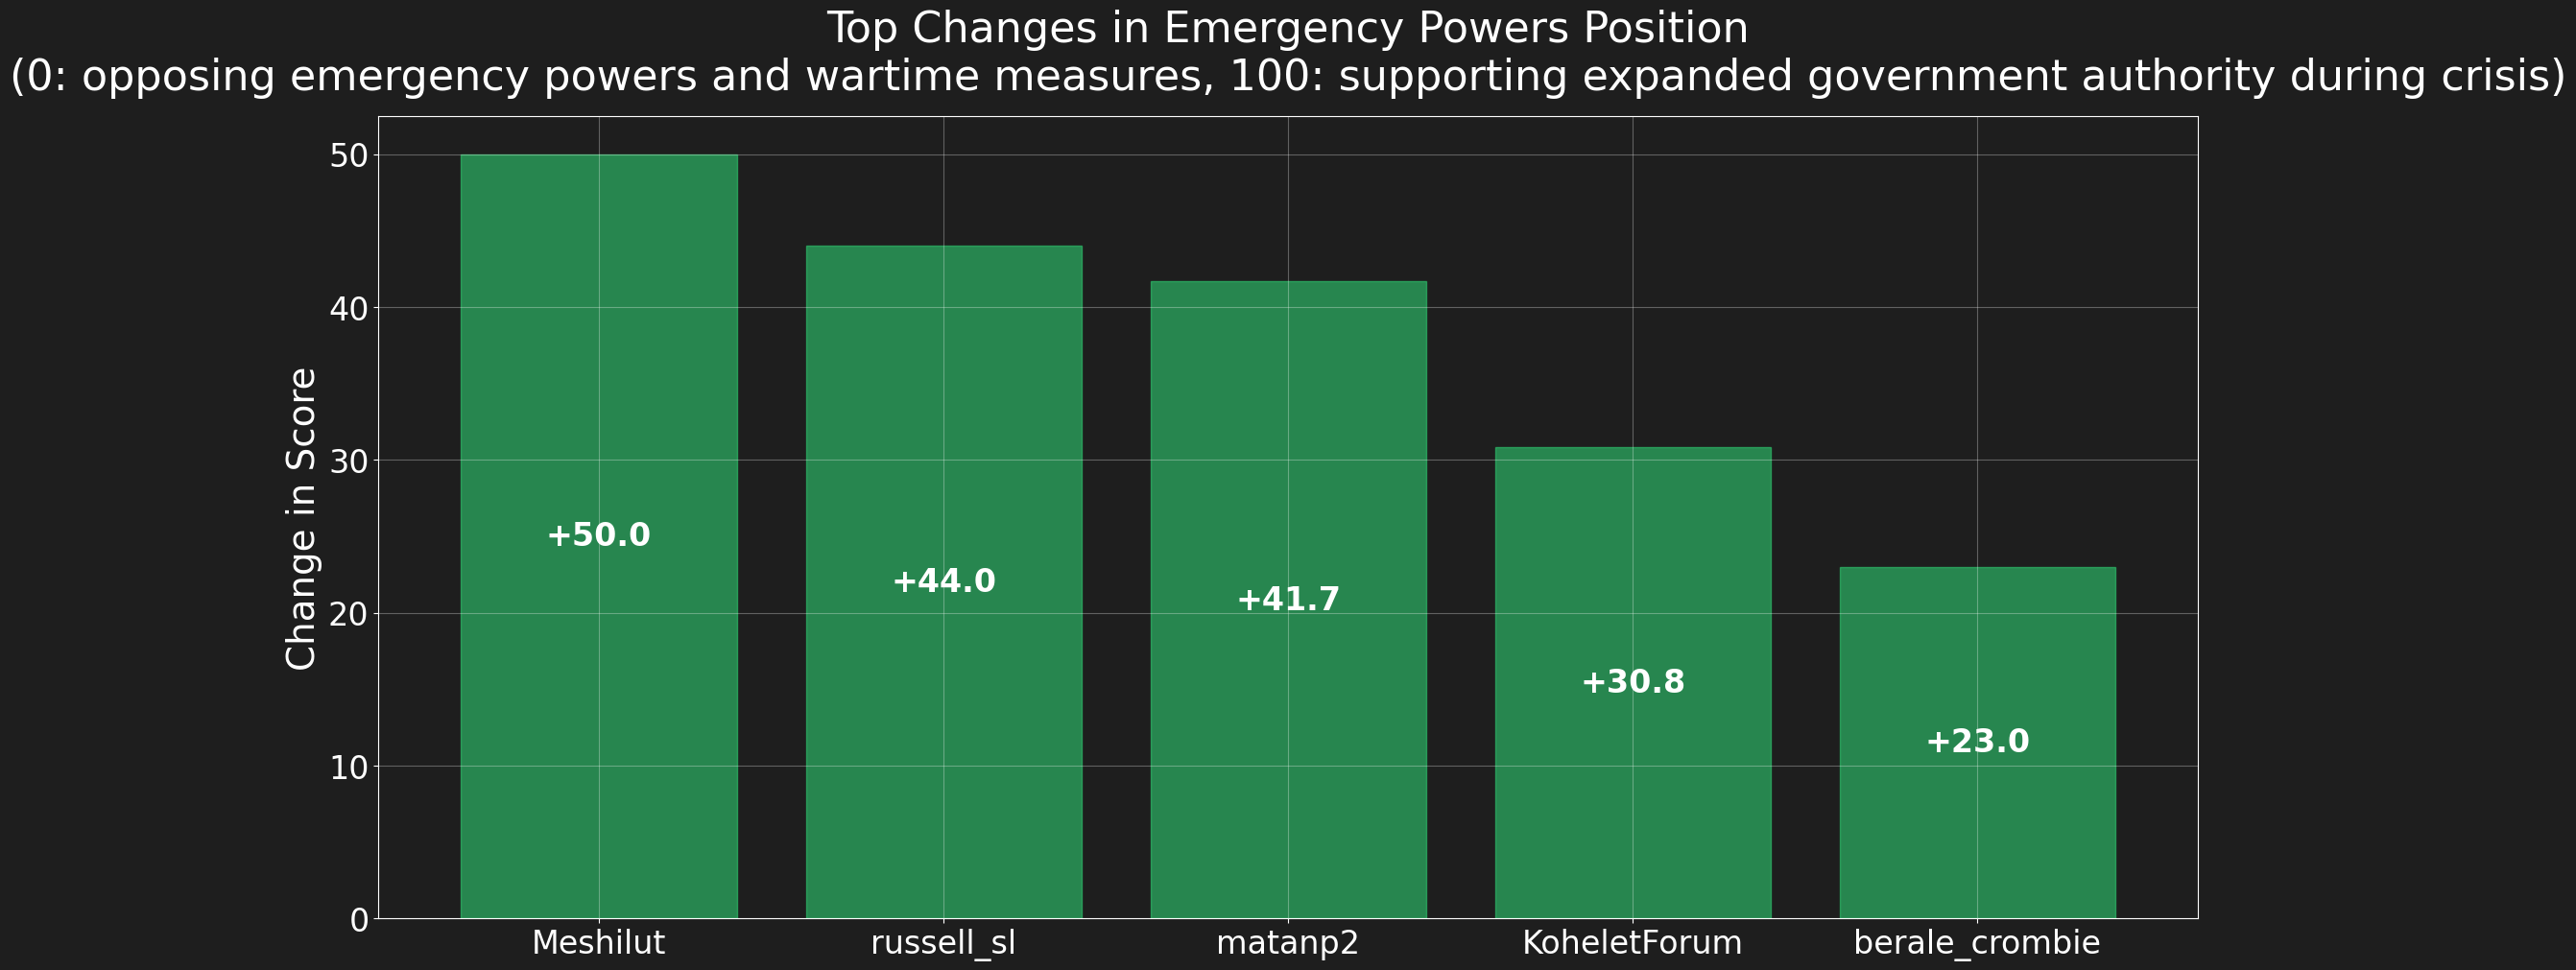

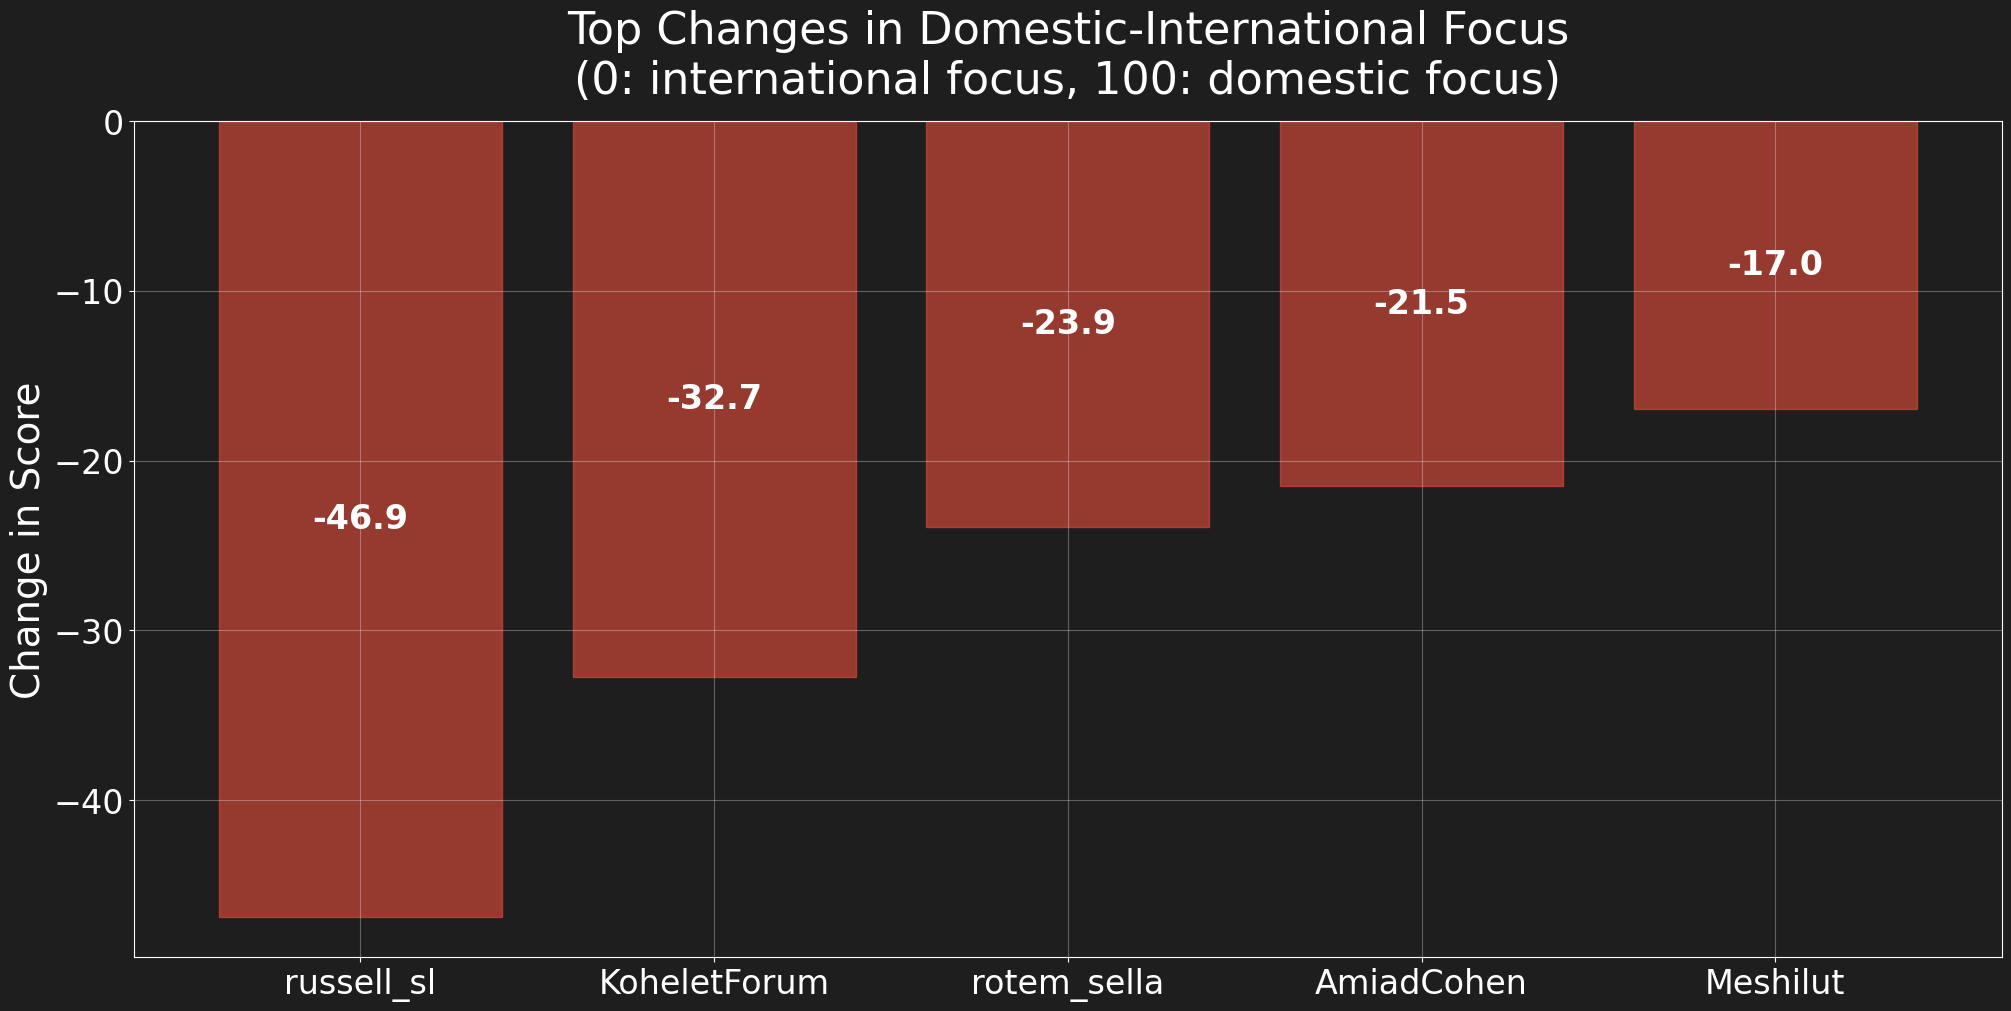

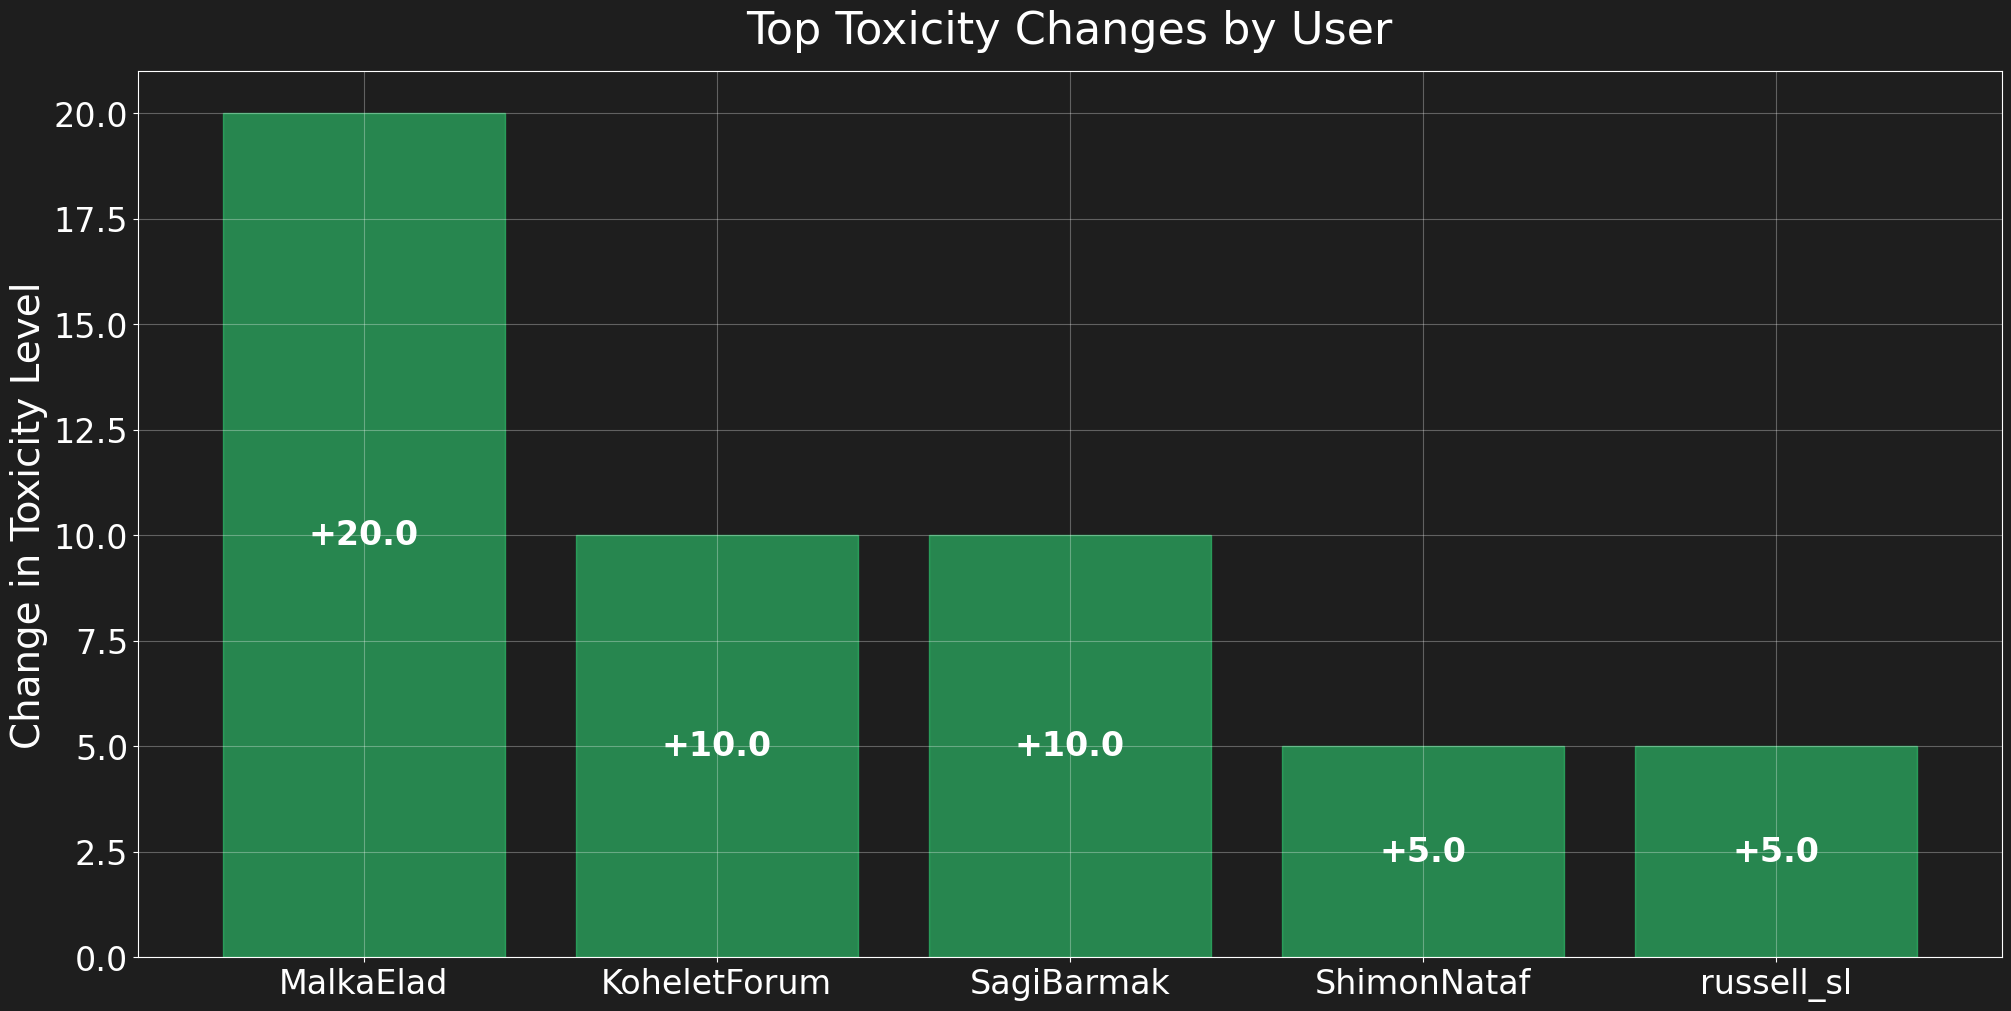

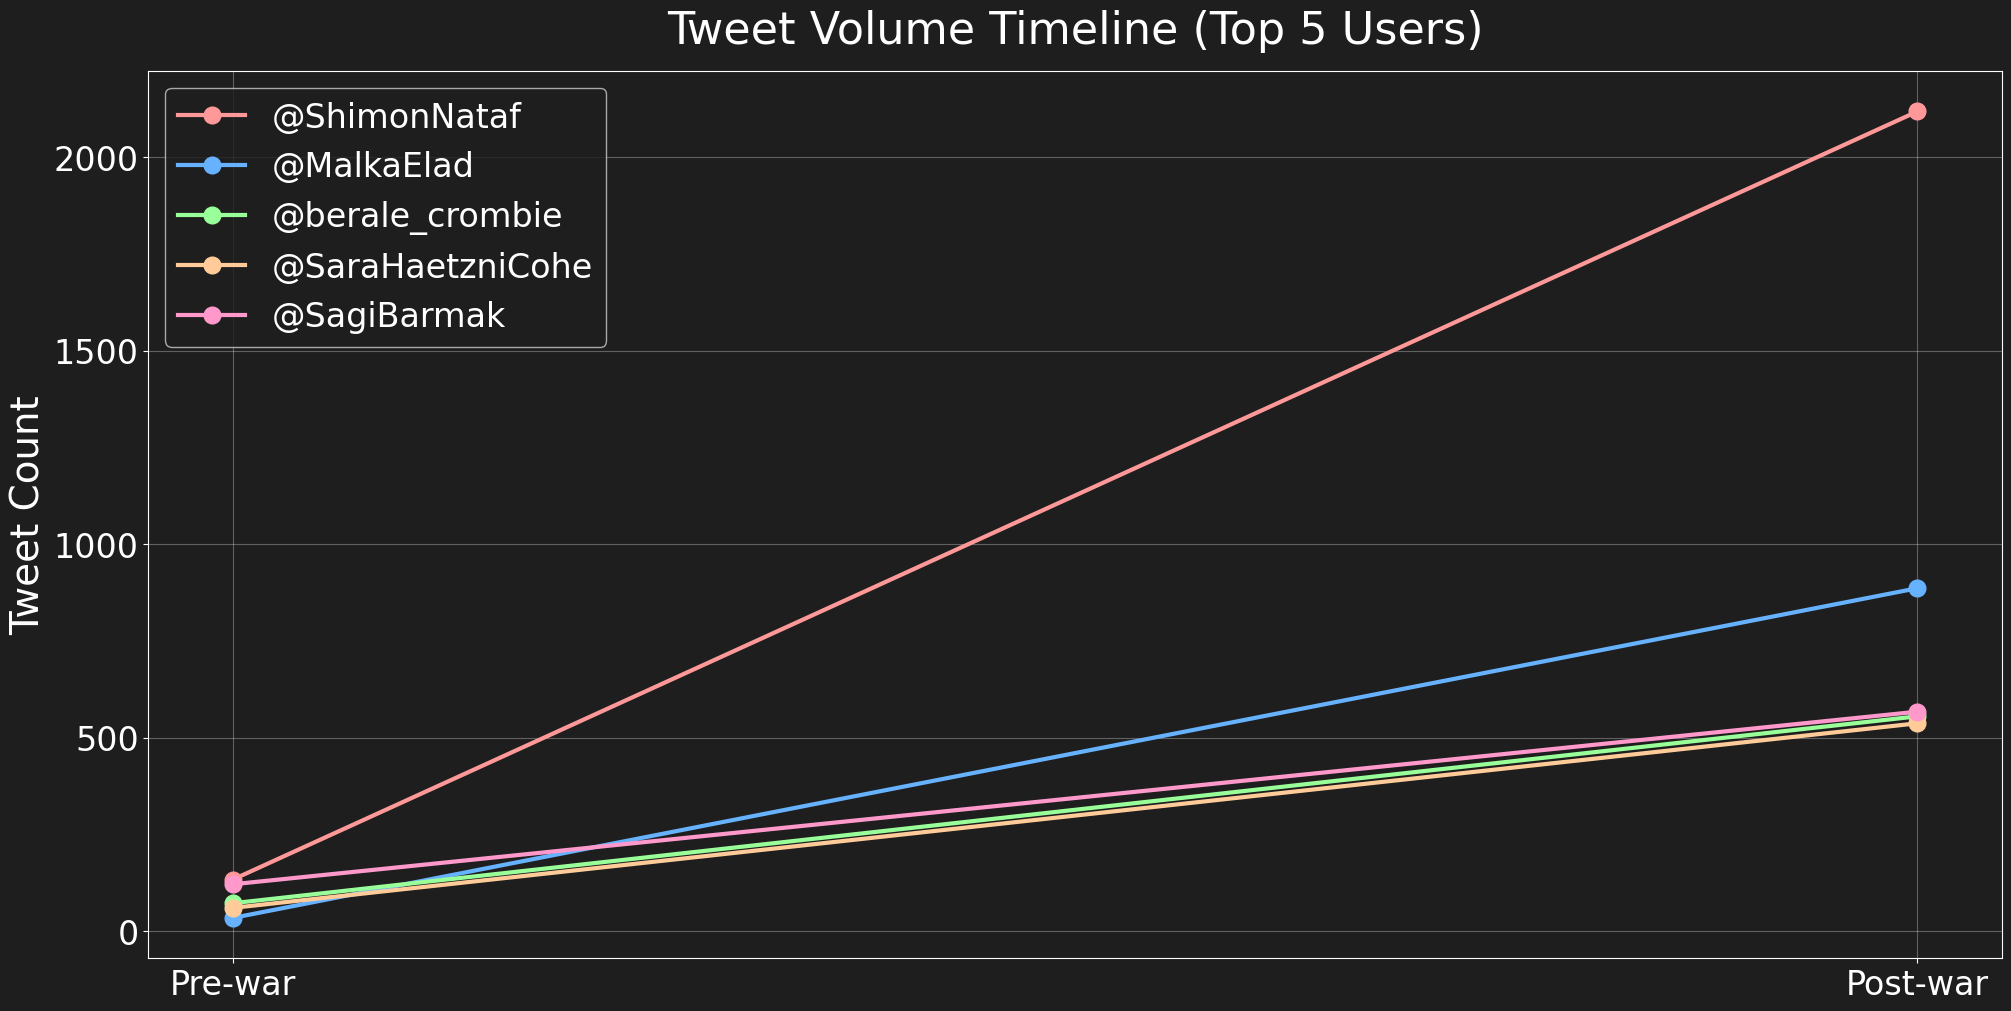

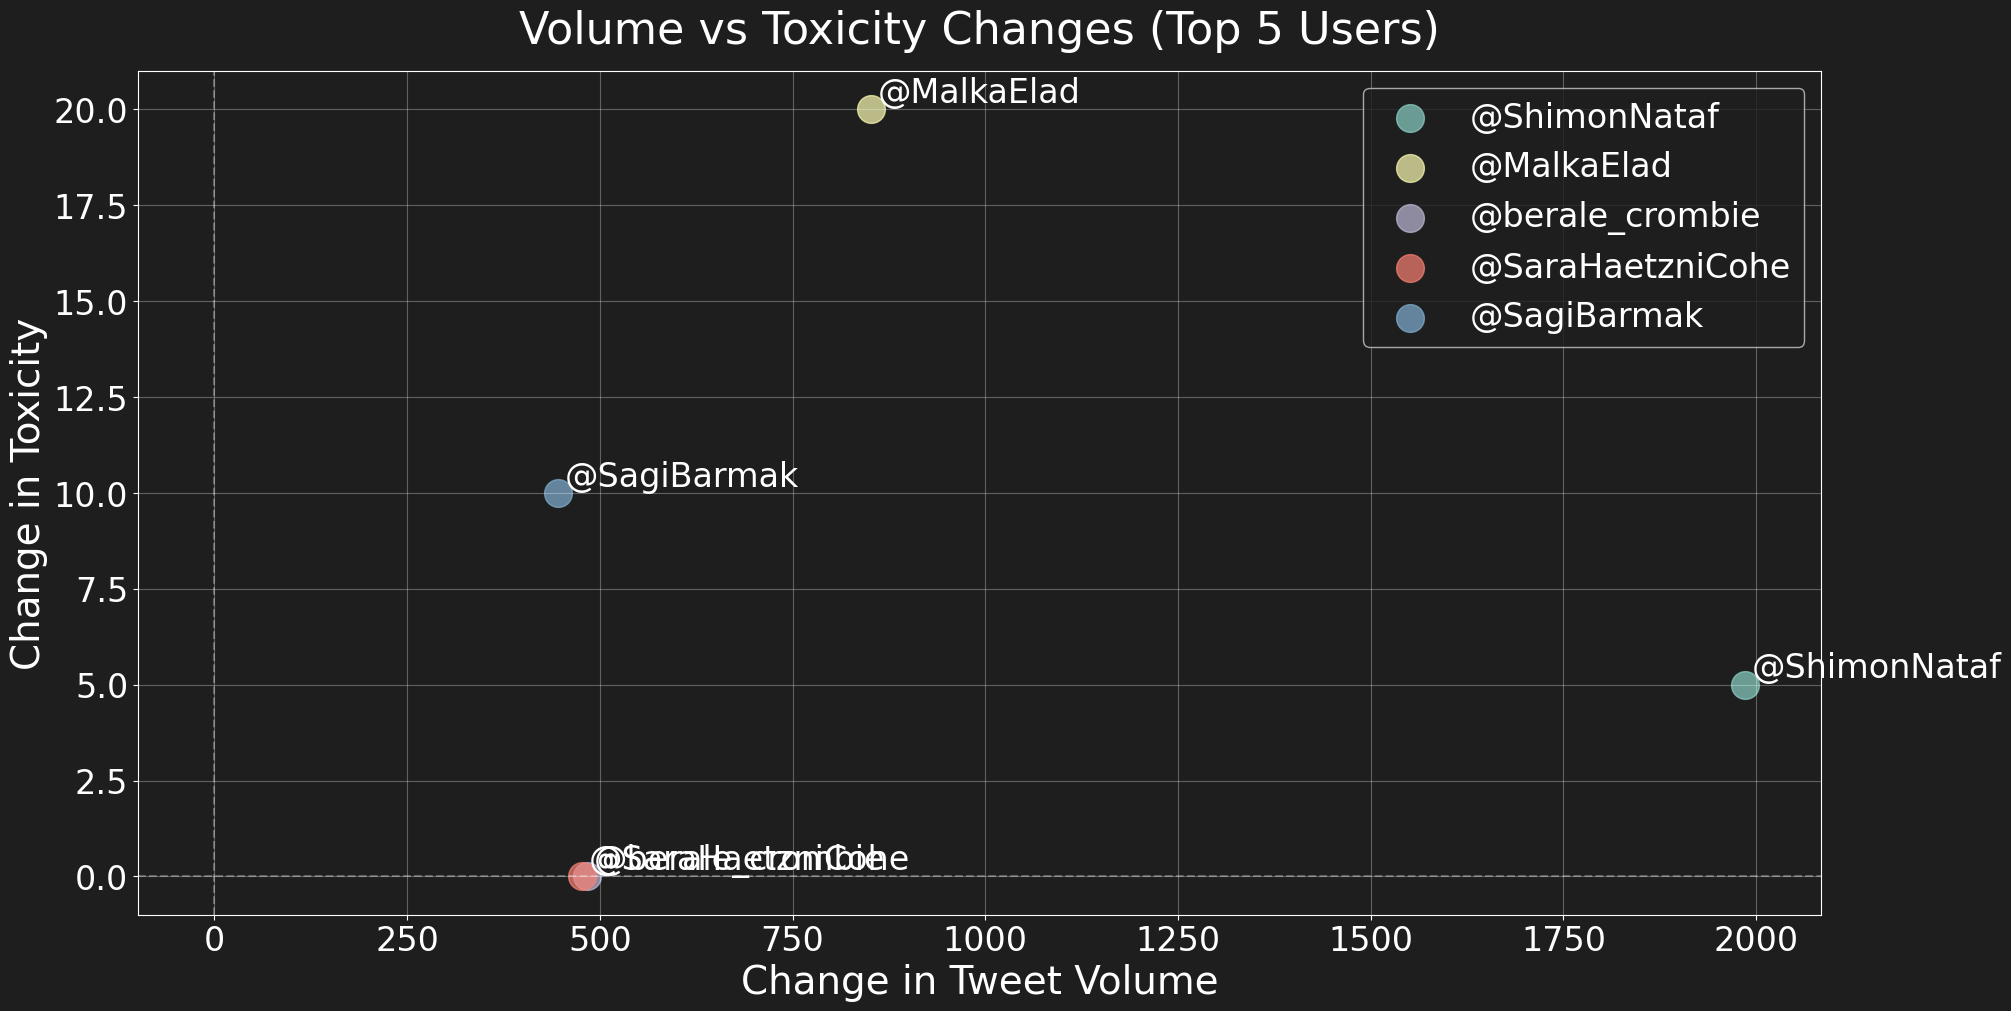

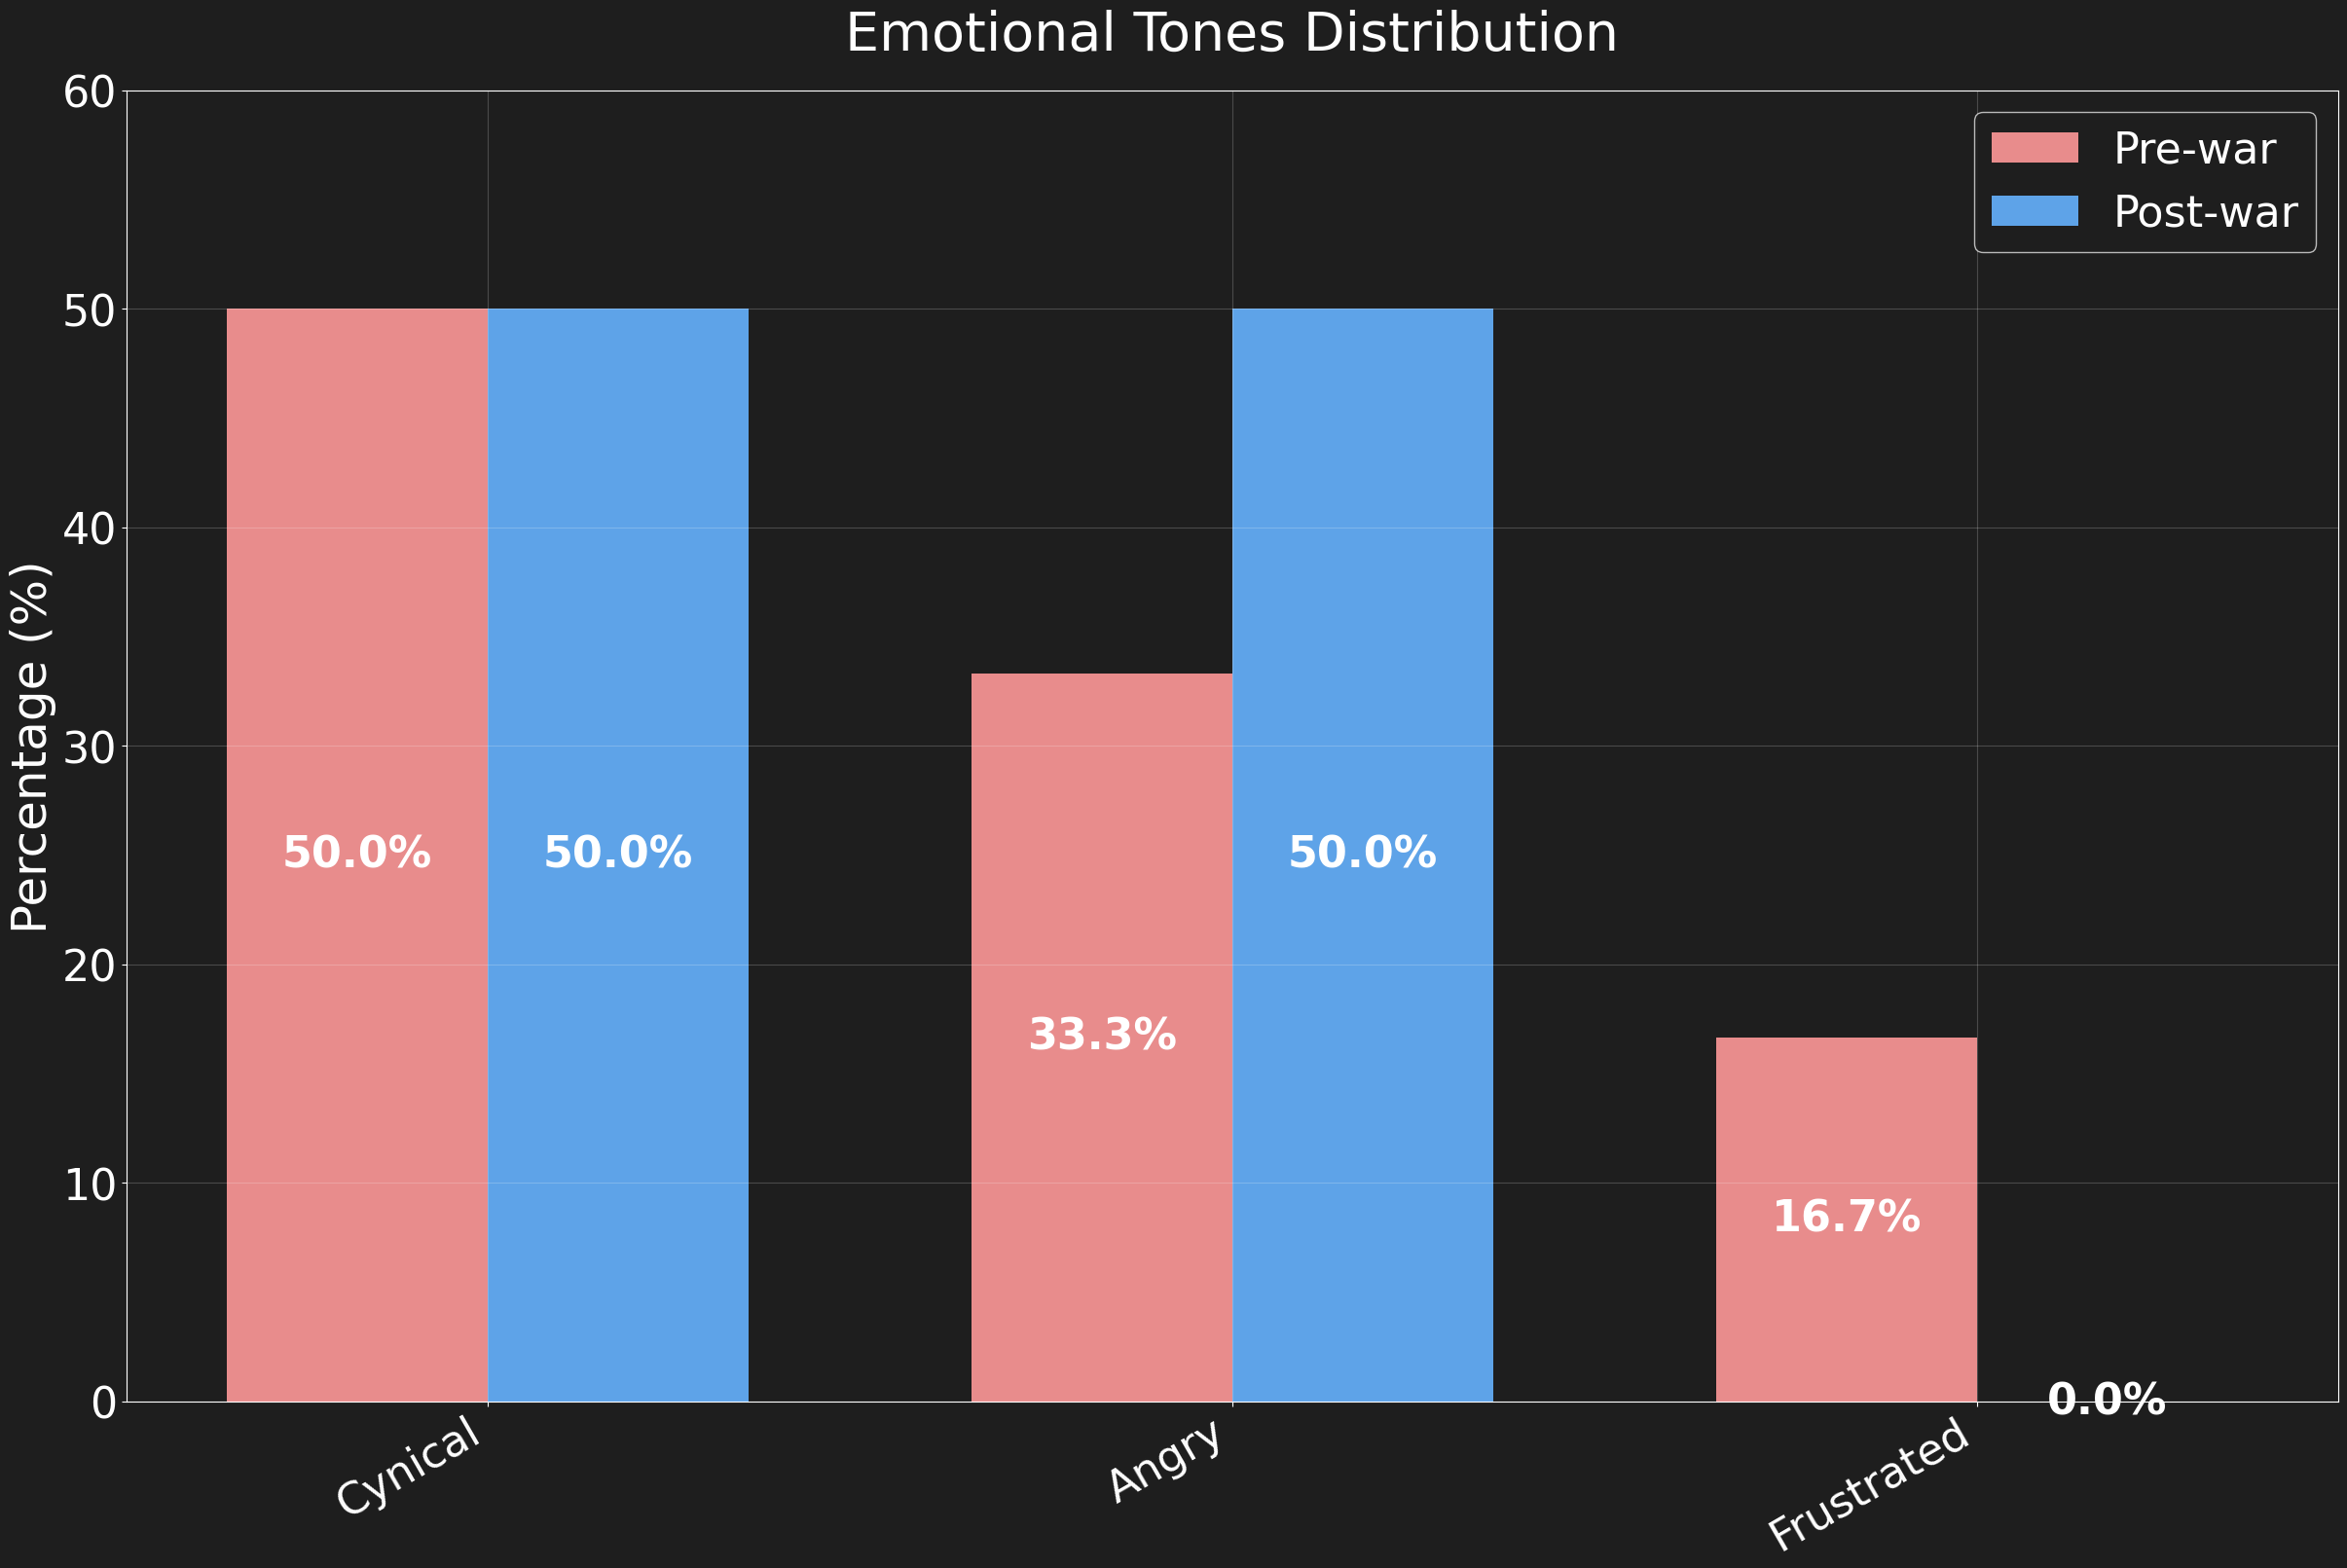

In [1]:
# Cell 6: Group Analysis
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from analyzer_group import GroupAnalyzer

# Find most recent enhanced analysis files
pre_war_pattern = 'data/analysis/pre_war/merged_analysis_pre_war_enhanced_*.csv'
post_war_pattern = 'data/analysis/post_war/merged_analysis_post_war_enhanced_*.csv'

# Get the most recent files
pre_war_files = glob.glob(pre_war_pattern)
post_war_files = glob.glob(post_war_pattern)

if pre_war_files and post_war_files:
    # Get most recent files
    pre_war_file = max(pre_war_files)
    post_war_file = max(post_war_files)
    
    # Read the data
    pre_war_data = pd.read_csv(pre_war_file)
    post_war_data = pd.read_csv(post_war_file)
    
    # Initialize group analyzer
    group_analyzer = GroupAnalyzer()
    
    # Generate group analysis
    results = group_analyzer.analyze_group(pre_war_data, post_war_data)
    
    # Generate and display report
    report_text, figures = group_analyzer.generate_report(results)
    display(Markdown(report_text))
    
    # Display figures
    for fig in figures:
        display(fig)
        plt.close(fig)  # Close figure to free memory
else:
    print("Error: Could not find analysis files")

Generate group report

In [2]:
# Export the reports to HTML
from html_exporter import HTMLExporter

# Initialize the exporter
exporter = HTMLExporter()

# Export group report using the already generated report_text and figures
output_path = exporter.export_report(report_text, figures)
print(f"Group report exported to: {output_path}")

Group report exported to: docs/index.html
